# CS5242 Project - Garbage Classification (Shanghai) - Group 27
For Neural Networks and Deep Learning (CS 5242) AY 2022-2023 Sem 1.
* Team member: Li Guoshen (A0237348X), An Yuhong (A0254379R), He Wenbin (A0237325H)
    * Github repository: https://github.com/HeWenbin-bobo/CS5242-Project-Garbage-Classification-Shanghai
    * Bokeh interative plot: [garbage_classification_plot_interactive](https://hewenbin-bobo.github.io/garbage_classification_plot_interactive.html)
    * Gradio online prediction: [CS5242-Project-Garbage-Classification-Shanghai (Gradio)](https://huggingface.co/spaces/wenbin1996/CS5242-Project-Garbage-Classification-Shanghai)

---

## Abstract
Increasing municipal garbage poses a great threat to city sustainability especially in developing countries. It has become one of the main sources of environmental pollution in Chinese cities. Accordingly, Urban Garbage Classification is of great significance to city sustainability. Essentially, it’s a social behavior and entails public participation. Based on Shanghai Garbage Classification System, MLP, CNN, and ANN models are utilized to solve the garbage classification problems. Our findings show that CNN and ANN models are more suitable for image handling. The best model, Vision Transformer, achieves an accuracy of 0.935 on the test set, suggesting its effectiveness on garbage classification. Also, some visualization tools are used to provide better analysis. Our study provides a new solution for urban garbage classification. It can be an useful tool for the government to protect environment and the sustainable development of cities.

## Problem introduction
* An inevitable consequence of intense human activities is the rapid increase in the amount of waste that is produced, and it is the way this waste is handled, stored, collected, and disposed of, which can pose risks to the environment and public health. At the heart of waste disposal is reasonable waste classification.
* **Different countries/cities may have proposed the details for garbage classification,but is not realistic for people to classify them without intelligent tools.**
    <br>
    <br>
* As an increasingly detailed understanding of environmental, social, and economic risks associated with managing various types of ‘waste’ has developed, various systems have been established to differentiate between materials.
* **However, most available systems do not accept pictures as input, which makes it difficult for citizens to inquire about waste types.**

## Motivation & Task description

* Both our algorithm model and the solution complement the gap between legislation and practice by developing an image-based waste sorting system. The system assists users in understanding the characteristics of waste so that it can be managed and monitored appropriately to protect human health and the environment.

* We Fetch the images of garbage by designing our **scrawler** and modifying their labels like Recyclable - Glasses to adapt our multi-class garbage classification model.

* Based on the optimal model among **MLP, CNN, and ANN**, users can get quick and accurate judgments on the waste types, improving the garbage classification quality.

* Additionally, a simple **front-end layer** is included in our solution that allows users to interact easily.

## Project Initialization

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import math
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [2]:
input_size = 128 # Input image size
crop_size = 112 # PicResize - crop
batch_size = 20 # Batch size
num_epochs = 20 # number of epochs for each model

In [3]:
get_labels_flag = False # Flag for determining whether to get trash label in Chinese
query_trash_type_flag = False # Flag for determining whether to get trash type from Shanghai Garbage Classification System and translate them into English through Baidu API
Flickr_crawler_flag = False # Flag for determining whether to redownload the images
data_cleaning_flag = False # Flag for determining whether to perform data cleaning, like removing some stange images through resnet and Kmeans, or removing some images with high similarity
resplit_dataset_flag = False # Flag for determining whether to resplit the dataset
over_sampling_flag = False # Flag for determining whether to perform over sampling so that #images of each type would be nearly the same in training dataset
gradio_show_flag = False # Flag for determining whether to create the front-end layer through Gradio and shown in notebook
model_retrain_flag = False # Flag for determining whether to retrain all the models, otherwise, load the trained ones

In [4]:
model_dict = dict() # Store all well_trainedd models in the format of {model_name: {model: trained_model, history: history}}
            # In `history`, we will record the history of loss on training/test dataset and accuracy on training/test dataset

In [5]:
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import os
import sys
from google.colab import drive
import shutil
!pip3 install git-lfs
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive')

# Since each time we will redownload all the data, please clean your trach folder regularly
if os.path.exists("/content/gdrive/My Drive/CS5242-Project-Garbage-Classification-Shanghai"):
    shutil.rmtree("/content/gdrive/My Drive/CS5242-Project-Garbage-Classification-Shanghai")
    print("Removed past data in /content/gdrive/My Drive/CS5242-Project-Garbage-Classification-Shanghai")

# What we have done have been uploaded onto github, please clone the files from the link
!git lfs clone https://github.com/HeWenbin-bobo/CS5242-Project-Garbage-Classification-Shanghai.git
os.chdir('/content/gdrive/My Drive/CS5242-Project-Garbage-Classification-Shanghai')
sys.path.append('/content/gdrive/My Drive/CS5242-Project-Garbage-Classification-Shanghai/Utils')
!git lfs prune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Removed past data in /content/gdrive/My Drive/CS5242-Project-Garbage-Classification-Shanghai
          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'CS5242-Project-Garbage-Classification-Shanghai'...
remote: Enumerating objects: 898, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 898 (delta 54), reused 229 (delta 28), pack-reused 639
Receiving objects: 100% (898/898), 276.09 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Checking out files: 100% (1132/1132), done.
Git LFS: (32 of 32 files) 1.39 GB / 1.39 GB
✔ 32 local objects, 32 retained
Nothing to prune


## Step 1: Get item labels

* Since we want to follow the rules of the Shanghai Garbage Classification system, we need to get Chinese labels for different items.

* First, we get the summary of Chinese names of junk items online.
  * https://zh.m.wikipedia.org/zh-sg/%E4%B8%8A%E6%B5%B7%E5%B8%82%E7%94%9F%E6%B4%BB%E5%9E%83%E5%9C%BE%E5%88%86%E7%B1%BB%E5%88%B6%E5%BA%A6
  * http://www.gjw123.com/tools-lajifenlei
  * etc.

* Then, we get the labels and save them in `labels.txt`.

* All these operations are done by `./Utils/get_labels.py`.

In [7]:
labels_save_path = './Labels'

In [8]:
if get_labels_flag:
    !python ./Utils/get_labels.py

## Step 2: Query garbage types on the Shanghai Garbage Classification platform according to labels

* Since we want to follow the rules of the Shanghai Garbage Classification System (and some labels might not be included in this system), we query the specific garbage types in Chinese first.
  * URL: https://trash.lhsr.cn/sites/feiguan/trashTypes_3/TrashQuery.aspx

* There are four main types included in Shanghai Garbage Classification System: `Recyclable (可回收)`， `Harmful waste (有害垃圾)`, `Dry garbage (干垃圾)`, `Wet garbage (湿垃圾)`. (Translated by Baidu)

* Based on Chinses results, we need to use Baidu Translate API to get their English names and save the final results into `labels.csv` in the format of (garbage_type, label).
    * Baidu API can apply at https://api.fanyi.baidu.com

* All these operations are done by `./Utils/query_trash_type.py`

In [9]:
from bs4 import BeautifulSoup
import time
import http.client
import hashlib
import urllib
import random
import json

In [10]:
if query_trash_type_flag:
    !python ./Utils/query_trash_type.py

## Step 3: Image Data Collection Using Off-the-Shelf API

* Many web platforms provide API for development. For example, we can use Flickr API to collect image data.

* Flickr is a well-known picture-sharing platform with a helpful API to facilitate developers to collect high-quality image data. For this project, the user may consider using the search query as the ground-truth label and collecting relevant images to train a classifier for certain tasks. 

* To use Flickr API, the user must first set up an account and apply for an *authentification key* from [this link](https://www.flickr.com/services/api/misc.api_keys.html). 

In [11]:
key = 'ada677c758306224de32e21219a644f5'
secret = 'f85284182c7b520b'

### 3.1 Install Python Flickr API and import necessary packages

In [12]:
import requests # send HTTP requests using Python, i.e., you can use requests to download files given the file link;
import pandas as pd # pandas help you store relevant information (file directory, label, etc.) in a csv or excel document;
from tqdm import tqdm # visualizes the progress and estimated remaining time of your data processing.

In [13]:
#uncomment if you have not yet installed flickrapi
!pip3 install flickrapi
from flickrapi import FlickrAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 3.2 Read labels and check their values

In [14]:
image_crawler_save_path = './Image_crawler'
if not os.path.exists(image_crawler_save_path):
    os.makedirs(image_crawler_save_path)
    print("We create a new folder {}".format(image_crawler_save_path))

In [15]:
labels_path = os.path.join(labels_save_path, 'labels.csv')
if not os.path.exists(labels_path):
    print("Path didn't exist!")
else:
    labels_pd = pd.read_csv(labels_path, names=['trash_type', 'item_type'])

print(labels_pd)

       trash_type    item_type
0      Recyclable       Carton
1      Recyclable    Newspaper
2      Recyclable     Envelope
3      Recyclable       Billet
4      Recyclable        Sheet
5      Recyclable       Pillow
6      Recyclable         Belt
7      Recyclable         Wire
8      Recyclable         Plug
9      Recyclable     Woodwork
10  Harmful waste      Battery
11  Harmful waste    Herbicide
12  Harmful waste        Paint
13  Harmful waste   Medicament
14  Harmful waste  Insecticide
15    Wet garbage         Rice
16    Wet garbage        Bread
17    Wet garbage         Duck
18    Wet garbage       Mutton
19    Wet garbage        Bacon
20    Wet garbage     Eggshell
21    Wet garbage        Scale
22    Wet garbage       Shrimp
23    Wet garbage        Squid
24    Wet garbage   Vegetables
25    Wet garbage     Truffle 
26    Wet garbage     Fishbone
27    Wet garbage        Candy
28    Wet garbage        Flour
29    Wet garbage        Petal
30    Dry garbage       Napkin
31    Dr

### 3.3 Acquire Image Links & Download files using acquired links

* *Flickrapi* provides a *walk* function that can walk through all photos in a set specified by a search result. Based on the URLs, we can download the corresponding images. This work is done by `./Utils/Flickr_crawler.py`.
    * To simplify our problem, we only download five types of trash images to perform classification.
        * `Newspaper` -> `Recyclable_Newspaper`
        * `Pillow` -> `Recyclable_Pillow`
        * `Battery` -> `Harmful waste_Battery`
        * `Vegetables` -> `Wet garbage_Vegetables`
        * `Pen` -> `Dry garbage_Pen`
        * This setting is defined in `./Utils/Flickr_crawler.py`.

In [16]:
flickr_scrape_save_path = os.path.join(image_crawler_save_path, 'Flickr_scrape')

In [17]:
if Flickr_crawler_flag:
    !python ./Utils/Flickr_crawler.py

In [18]:
# Check the types of images downloaded
labels_dict_path = os.path.join(labels_save_path, 'labels_dict.npy')
if not os.path.exists(labels_dict_path):
    print("{} didn't exist!".format(labels_dict_path))
else:
    labels_dict = np.load(labels_dict_path, allow_pickle=True).item()

print(labels_dict)

{'Newspaper': 'Recyclable_Newspaper', 'Pillow': 'Recyclable_Pillow', 'Battery': 'Harmful waste_Battery', 'Vegetables': 'Wet garbage_Vegetables', 'Pen': 'Dry garbage_Pen'}


### 3.4 Visualize Collected Image Data in Notebook

Visualize sample images in a jupyter notebook

In [19]:
import ipywidgets as widgets
from glob import glob
from matplotlib import pyplot as plt
import cv2

In [20]:
def plot_samples(category, flickr_scrape_save_path):
    paths = sorted(glob(f'./{flickr_scrape_save_path}/{category}/*.*'))
    paths = np.random.choice(paths, 4, replace=False)

    plt.figure(figsize=(12,12))
    for i in range(4):
        image = cv2.imread(paths[i])[...,[2,1,0]]
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_LINEAR)
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


all_categories = labels_dict.values()
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: plot_samples(category, flickr_scrape_save_path), category=all_categories)

interactive(children=(Dropdown(description='category', options=('Recyclable_Newspaper', 'Recyclable_Pillow', '…

### 3.5 Data Exploration, Exploitation, and Analysis

Visualizing the distribution of image size and ratio can help later design shapes of model architecture, as well as finding and removing images with extreme ratios.

In [21]:
import seaborn as sns

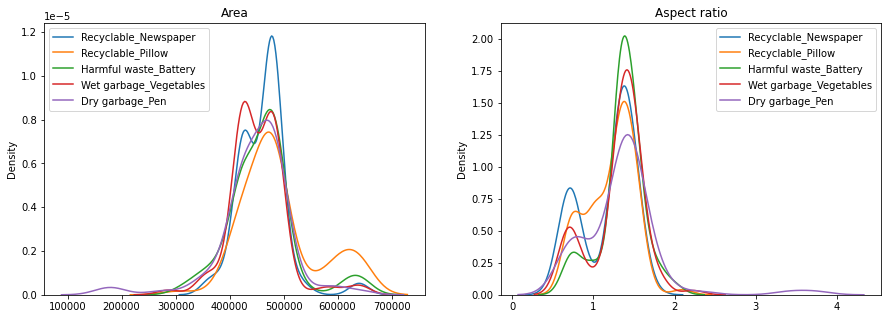

In [22]:
def get_size(path):
    image = cv2.imread(path)
    shape = image.shape[:2]

    return shape[1]*shape[0], shape[1]/shape[0]
  

all_categories = labels_dict.values()
sizes = []
ratios = []
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
for i, species in enumerate(all_categories):
    paths = sorted(glob(f'{flickr_scrape_save_path}/{species}/*.*'))
    output = np.array([get_size(path) for path in paths])
      
    sizes.append(output[:,0])
    ratios.append(output[:,1])

    sns.kdeplot(output[:,0], label = species, ax=ax0)
    sns.kdeplot(output[:,1], label = species, ax=ax1)

ax0.set_title('Area')
ax1.set_title('Aspect ratio')
ax0.legend()
ax1.legend()
plt.show()

## Step 4: Data cleaning

* Since the actual content of some images downloaded from the Internet may not match the labels, we need to remove these images from our dataset.
* One way is to use **Kmeans** to group images and remove the cluster with the lowest count. When only using Kmeans to group images, the difference in pixel values is used, but the features of the image are not considered. 
* (Default) Another way is first using **Resnet50** to extract the features of each data to obtain multiple data features. Next, performing clustering processing on the multiple data features to obtain clustering results. Then, removing the abnormal pictures according to the clustering results.
<br>                                                        <br>  

* In addition, we use **structural_similarity** to remove some highly similar images to clean our dataset.
* Since we may download some images, it is unfeasible to quickly calculate pair-wise similarity for all images.
* We determine to sort these images randomly. As a result, each image will only be compared to the next. When the similarity is higher than the threshold (0.8), the image will be moved to `./Trash/`. This process loops ten times by default.
* All these operations are done by `./Utils/data_cleaning.py`.

In [23]:
from torch.utils.data import Dataset
from PIL import Image
from sklearn.cluster import KMeans
from imutils import build_montages
import matplotlib.image as imgplt
from google.colab.patches import cv2_imshow
import torchvision.models as models
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from skimage.metrics import structural_similarity as ssim

In [24]:
trash_path = "./Trash/"

In [25]:
if data_cleaning_flag:
    !python ./Utils/data_cleaning.py # Default is to remove the strange images through Resnet50&Kmeans. If you want to use only Kmeans, please pass 'Kmeans'.

## Step 5: Dataset Generation

### 5.1 Load all images and split them into train/test folder

In [26]:
def makedir(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
        print("We create a new folder {}".format(new_dir))


def train_test_dataset_split(flickr_scrape_save_path, dataset_save_path, train_dataset_save_path, test_dataset_save_path):
    try:
        shutil.rmtree(train_dataset_save_path)
        print(f"Removed past data in {train_dataset_save_path}")
    except OSError as e:
        print("Error: %s : %s" % (train_dataset_save_path, e.strerror))
    
    try:
        shutil.rmtree(test_dataset_save_path)
        print(f"Removed past data in {test_dataset_save_path}")
    except OSError as e:
        print("Error: %s : %s" % (test_dataset_save_path, e.strerror))

    for root, dirs, files in os.walk(flickr_scrape_save_path):
        for sub_dir in dirs:

            imgs = os.listdir(os.path.join(root, sub_dir))
            imgs = list(filter(lambda x: x.endswith('.jpg'), imgs))
            random.shuffle(imgs)
            img_count = len(imgs)

            train_point = int(img_count * train_pct)

            for i in range(img_count):
                if i < train_point:
                    out_dir = os.path.join(train_dataset_save_path, sub_dir)
                else:
                    out_dir = os.path.join(test_dataset_save_path, sub_dir)

                makedir(out_dir)

                source_path = os.path.join(flickr_scrape_save_path, sub_dir, imgs[i])
                target_path = os.path.join(out_dir, imgs[i])

                shutil.copy(source_path, target_path)

            print('Class:{}, train:{}, test:{}'.format(sub_dir, train_point, img_count-train_point))


dataset_save_path = "./Dataset/"
makedir(dataset_save_path)
train_dataset_save_path = os.path.join(dataset_save_path, "train")
test_dataset_save_path = os.path.join(dataset_save_path, "test")
train_pct = 0.9
test_pct = 0.1

if resplit_dataset_flag:
    print('Start spliting train/test dataset')
    train_test_dataset_split(flickr_scrape_save_path, dataset_save_path, train_dataset_save_path, test_dataset_save_path)

#### Over Sampling - Geometric SMOTE

* One problem we found is that the number of images used for each category differs.  Although we initially set the same data for each category when downloading pictures, the final number of pictures for each category is inconsistent due to network reasons, platform limitations, data cleaning, etc.
* To balance the number of images in each class, we use over-sampling to increase the number of samples from the minority class.
* The **Geometric-SMOTE** algorithm used in our project strengthens the data generation mechanism of SMOTE by generating artificial samples within a geometric region around each selected minority class sample.

* This operation is done by `./Utils/over_sampling.py`.
* First, we explore the influence of different values for three hyperparameters:
 * `strategies: ["combined", "majority", "minority"]`
 * `ds: [0, 0.5, 1]`
 * `ts: [-1, 0, 1]`
* Then, we use `strategies="minority"`, `ds=1`, and `ts=1` to add more samples.

* **References**: [Geometric SMOTE a geometrically enhanced drop-in replacement for SMOTE](https://www.sciencedirect.com/science/article/abs/pii/S0020025519305353)

In [27]:
!pip3 install -U geometric-smote

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from gsmote import GeometricSMOTE
from sklearn.preprocessing import LabelEncoder

In [29]:
# Function for loading all images under a specific folder
def images_df(dataset_save_path):
    all_images = []
    all_images_labels = []
    flag = True
    for root, dirs, files in os.walk(dataset_save_path):
        for label_dir in dirs:
            imgs = os.listdir(os.path.join(root, label_dir))
            imgs = list(filter(lambda x: x.endswith('.jpg'), imgs))
            for img_name in imgs:
                image = Image.open(os.path.join(root, label_dir, img_name))
                image = np.array(image.convert("RGBA"))
                image = image / 255.0
                image = cv2.resize(image, (100, 100), interpolation=cv2.INTER_LINEAR)
                if flag:
                    flag = False
                image = image.reshape(-1,)
                all_images.append(image)
                all_images_labels.append(os.path.join(root, label_dir))
    
    X = pd.DataFrame(all_images)
    X = X.add_prefix('X')
    y = pd.DataFrame(all_images_labels, columns=['label'])
    y['label'] = y['label'].astype('category')
    labelencoder = LabelEncoder()
    y['label'] = labelencoder.fit_transform(y['label'])

    return X, y, labelencoder

In [30]:
# Check the numbers of images for each trash type before over sampling
if over_sampling_flag:
    _, y_oversampling, _ = images_df(train_dataset_save_path)
    print(y_oversampling.groupby('label')['label'].count())

In [31]:
if over_sampling_flag:
    !python ./Utils/over_sampling.py

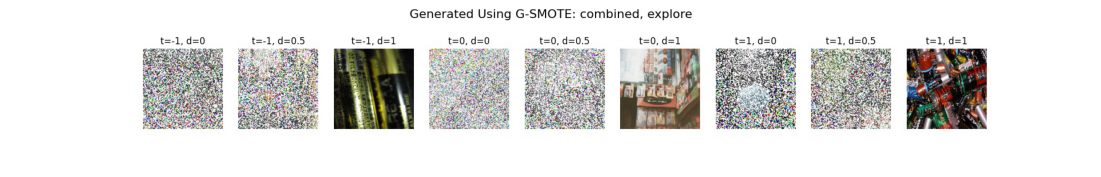

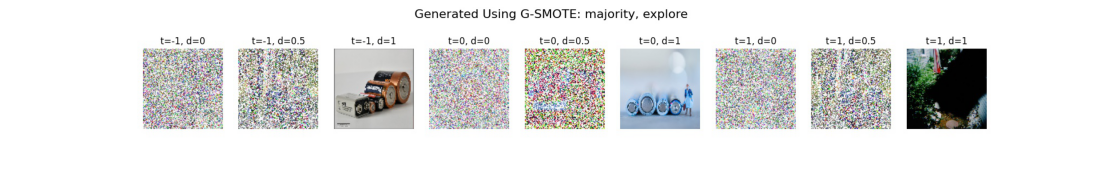

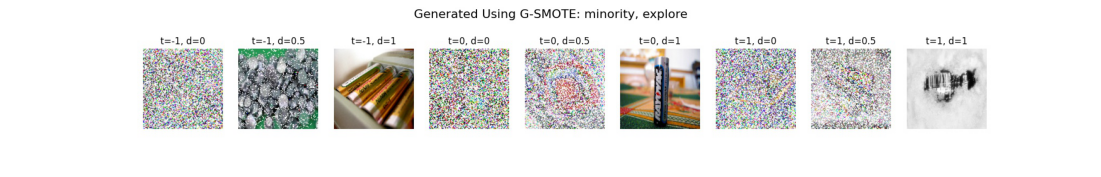

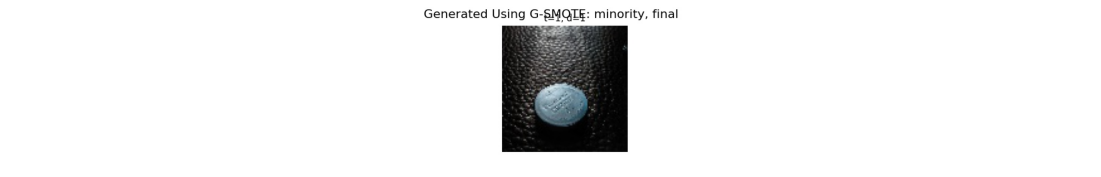

In [32]:
strategies=["combined", "majority", "minority"]
for strategy in strategies:
    picture_name = f"Generated Using G-SMOTE {strategy}, {'explore' if len(strategies)==3 else 'final'}"
    img = Image.open(os.path.join('./Figure/Over Sampling', picture_name + '.jpg'))
    plt.figure(figsize=(20, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

strategies=["minority"]
for strategy in strategies:
    picture_name = f"Generated Using G-SMOTE {strategy}, {'explore' if len(strategies)==3 else 'final'}"
    img = Image.open(os.path.join('./Figure/Over Sampling', picture_name + '.jpg'))
    plt.figure(figsize=(20, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [33]:
# Check the numbers of images for each trash type after over sampling.
_, y_oversampling_after, _ = images_df(train_dataset_save_path)
y_oversampling_after.groupby('label')['label'].count()

label
0    81
1    80
2    81
3    81
4    81
Name: label, dtype: int64

### 5.2 Calculate the std and mean value for each channel

To normalize our images, we should first calculate each channel's std and mean values.

Our data determines whether to use the average and standard deviation of ImageNet. Assuming our data are ordinary photos of "natural scenes" (e.g. people, buildings, animals, varied lighting/angles/backgrounds), and biased in the same way ImageNet is (in terms of class balance). Then, it is good to normalize with ImageNet's scene statistics. Suppose the photos are "special" somehow (e.g. colour filtered, contrast adjusted, uncommon lighting) or an "unnatural subject" (e.g. medical images, satellite imagery, hand drawings), we would recommend correctly normalizing the user's dataset before the model training.

**References**: [Why Pytorch officially use mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] to normalize images?](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)

In [34]:
from torchvision import datasets
import torch.optim as optim
from torch.utils.data import DataLoader

In [35]:
def calculate_std_mean_RGB(train_dataset_save_path):
    train_dataset = datasets.ImageFolder(root=train_dataset_save_path, transform=transforms.ToTensor())
    train_dataset_loader = DataLoader(train_dataset)

    N_CHANNELS = 3
    print('==> Computing mean and std..')
    mean = torch.zeros(N_CHANNELS)
    std = torch.zeros(N_CHANNELS)
    for inputs, _labels in tqdm(train_dataset_loader):
        for i in range(N_CHANNELS):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(train_dataset_loader.dataset))
    std.div_(len(train_dataset_loader.dataset))
    print(mean, std)

    return mean, std

mean_RGB, std_RGB = calculate_std_mean_RGB(train_dataset_save_path)

==> Computing mean and std..


100%|██████████| 404/404 [00:14<00:00, 27.69it/s]

tensor([0.4852, 0.4446, 0.3975]) tensor([0.2429, 0.2364, 0.2319])


### 5.3 Data preprocessing

This section includes data resizing, data enhancement (image flipping and other operations), normalization, and conversion to tensor.

In [36]:
if resplit_dataset_flag:
    image_transforms = {
        'train': transforms.Compose([
            transforms.Resize(size=input_size),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomResizedCrop(size=crop_size, scale=(0.8, 1.0)),
            transforms.CenterCrop(size=crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean_RGB.tolist(), std_RGB.tolist())
        ]),
        'test': transforms.Compose([
            transforms.Resize(size=input_size),
            transforms.CenterCrop(size=crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean_RGB.tolist(), std_RGB.tolist())
        ])
    }


    #load image data
    data = {
        'train': datasets.ImageFolder(root=train_dataset_save_path, transform=image_transforms['train']),
        'test': datasets.ImageFolder(root=test_dataset_save_path, transform=image_transforms['test'])
    }
    
    
    train_data_size = len(data['train'])
    test_data_size = len(data['test'])
    
    train_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

    classes = data['train'].class_to_idx
    classes_num = len(data['train'].class_to_idx)

    torch.save(train_loader, dataset_save_path + 'train_loader.pt')
    torch.save(test_loader, dataset_save_path + 'test_loader.pt')
    torch.save(classes, dataset_save_path + 'classes.pt')
    torch.save(image_transforms, dataset_save_path + 'transform.pt')

### 5.4 Load train/test dataset

In [37]:
train_loader = torch.load(dataset_save_path + 'train_loader.pt', map_location=torch.device('cpu'))
test_loader = torch.load(dataset_save_path + 'test_loader.pt', map_location=torch.device('cpu'))
classes = torch.load(dataset_save_path + 'classes.pt', map_location=torch.device('cpu'))
image_transforms = torch.load(dataset_save_path + 'transform.pt', map_location=torch.device('cpu'))

classes_num = len(classes)
train_data_size = len(train_loader.dataset)
test_data_size = len(test_loader.dataset)

In [38]:
print(f'Number of classes: {classes_num}') # number of classes

Number of classes: 5


In [39]:
print(f'Class names and their index: {classes}') # class names

Class names and their index: {'Dry garbage_Pen': 0, 'Harmful waste_Battery': 1, 'Recyclable_Newspaper': 2, 'Recyclable_Pillow': 3, 'Wet garbage_Vegetables': 4}


In [40]:
print(f'Overall number of train samples: {train_data_size}') # overall number of train samples, or len(train_loader.datasets)

Overall number of train samples: 404


In [41]:
print(f'Number of batches: {len(train_loader)}') # number of batches

Number of batches: 21


### 5.5 Define general function and parameters

In [42]:
from torchsummary import summary
from torchvision import models
import copy
import gc

In [43]:
!pip3 install torchviz
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
if model_retrain_flag: # Remove past models
    try:
        shutil.rmtree('./Models')
        print(f"Removed past scrape in ./Models")
    except OSError as e:
        print("Error: %s : %s" % ('./Models', e.strerror))

In [45]:
if model_retrain_flag: # Remove past figures
    try:
        shutil.rmtree('./Figure/Models')
        print(f"Removed past scrape in ./Figure/Models")
    except OSError as e:
        print("Error: %s : %s" % ('./Figure/Models', e.strerror))
    
    try:
        shutil.rmtree('./Figure/Summary')
        print(f"Removed past scrape in ./Figure/Summary")
    except OSError as e:
        print("Error: %s : %s" % ('./Figure/Summary', e.strerror))

In [46]:
if model_retrain_flag: # Remove past figures about model structures
    try:
        shutil.rmtree('./Presentation/modelStructure/')
        print(f"Removed past scrape in ./Presentation/modelStructure/")
    except OSError as e:
        print("Error: %s : %s" % ('./Presentation/modelStructure/', e.strerror))

* **General functions**:
    * `weight_initialization`: For weight initizalition

    * `train_and_test`: Automatically train and test the model (including early stopping and best model saving)

    * `history_save`: Save the history of training loss, test loss, training accuracy, and test accuracy.

    * `result_figure_save`: Draw the history of training and save it.

    * `weight_plot`: Plot the weight distribution of the first layer.

    * `model_structure_plot`: Plot the model structure through `torchviz`.

    * `display_num_param`: Show the overall number of parameters for a model.

    * `model_load`: Load a pre-trained model.

    * `bar_plot`: Bar plot (usually for summary).

In [47]:
from general_function import weight_initialization, train_and_test, history_save, result_figure_save, weight_plot, model_structure_plot, display_num_param, model_load, bar_plot

## Step 6: MLP

* In this part, we build four types of MLP models as the baseline.
    1. Multi-layer model
    2. Multi-layer with kaiming weight initialization.
    3. Multi-layer with kaiming weight initialization and weight decay.
    4. Multi-layer with kaiming weight initialization and weight decay. (But we use genetic algorithm to update weight instead of gradient descend to avoid gradient disappear.)

In [48]:
hidden_size = 128
fc_inputs = 3*crop_size**2

### 6.1 Multi-layer

In [49]:
model_name = 'MLP/6_1'

MLP_6_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(fc_inputs, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, classes_num),
)
MLP_6_1 = MLP_6_1.to(device)

optimizer = optim.Adam(MLP_6_1.parameters())

# summary(MLP_6_1, (fc_inputs,))
display_num_param(MLP_6_1)

There are 4834181 (4.83 million) parameters in this neural network


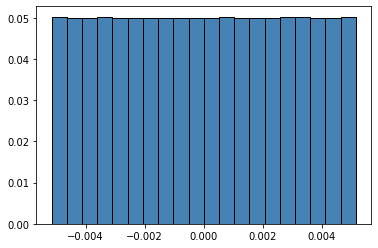

In [50]:
weight_plot(MLP_6_1, model_name)

In [51]:
# model_structure_plot(MLP_6_1, model_name, crop_size=crop_size)

Best Accuracy for test : 41.3043%, best loss: 2.3050
Accuracy for train : 69.5545%, loss: 1.1185


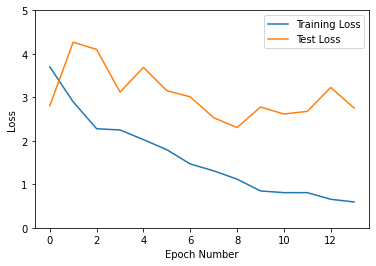

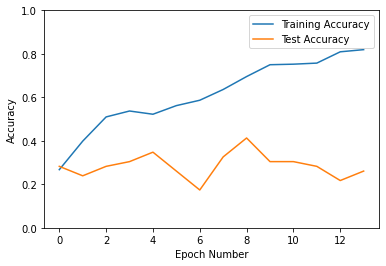

In [52]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, MLP_6_1, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

After training the model, we can see that the distribution of weights becomes a normal distribution, still maintaining a symmetric structure. A normally distributed weight means that some pixels of the image will have a greater impact, not all pixels are equally important. This is why adding an attention mechanism may improve accuracy.

We can see that the accuracy on training/test dataset is different. It means that our model may meet the problem of overfitting. So we continue to explore more methods to solve this.

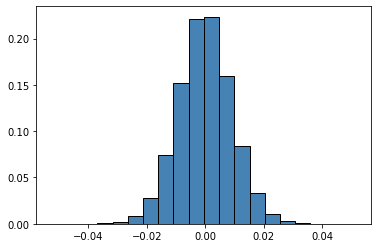

In [53]:
weight_plot(trained_model, model_name)

### 6.2 Multi-layer with kaiming weight initialization

* Instead of the default initialization, we use kaiming initialization here.
    * Xavier initialization assumes that there is no activation function in the network, and the activation function will change the distribution of the flowing data in the neural network. Kaiming Initialization is proposed to solve this problem.
    
* **References**: [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

In [54]:
model_name = 'MLP/6_2'

MLP_6_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(fc_inputs, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, classes_num),
)
MLP_6_2 = MLP_6_2.to(device)

weight_initialization(MLP_6_2)

optimizer = optim.Adam(MLP_6_2.parameters())

# summary(MLP_6_2, (fc_inputs,))
display_num_param(MLP_6_2)

There are 4834181 (4.83 million) parameters in this neural network


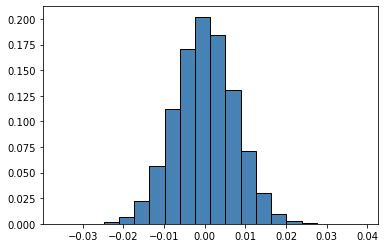

In [55]:
weight_plot(MLP_6_2, model_name)

Best Accuracy for test : 32.6087%, best loss: 14.8658
Accuracy for train : 51.9802%, loss: 6.6556


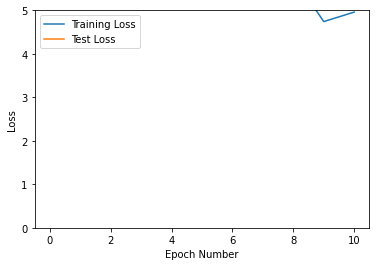

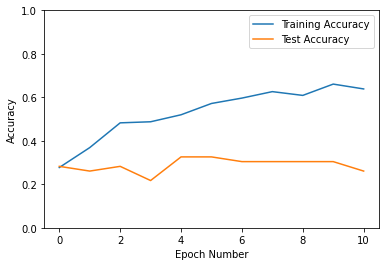

In [56]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, MLP_6_2, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

After training the model, we can see that the distribution of weights is still a normal distribution, but not maintaining a perfect symmetric structure. And test accuracy decreased to 32.6087% (lower than that of `6.1` model - 41.3043%).

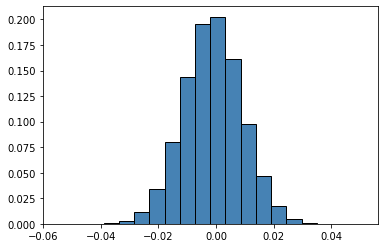

In [57]:
weight_plot(trained_model, model_name)

### 6.3 Multi-layer with kaiming weight initialization and weight decay

**Weight Decay**, or **$L_2$ Regularization**, is a regularization technique applied to the weights of a neural network. We minimize a loss function compromising both the primary loss function and a penalty on the  Norm of the weights:

$$L _ { n e w } ( w ) = L _ { \text {original } } ( w ) + \lambda w ^ { T } w$$

where $\lambda$ is a value determining the strength of the penalty (encouraging smaller weights).

Weight decay can be incorporated directly into the weight update rule, rather than just implicitly by defining it through to objective function. Often weight decay refers to the implementation where we specify it directly in the weight update rule (whereas $L_2$ Regularization is usually the implementation which is specified in the objective function).

**References**: [Weight Decay](https://paperswithcode.com/method/weight-decay)

In [58]:
model_name = 'MLP/6_3'

MLP_6_3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(fc_inputs, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, classes_num),
)
MLP_6_3 = MLP_6_3.to(device)

weight_initialization(MLP_6_3)

optimizer = optim.Adam(MLP_6_3.parameters(), weight_decay=1e-2)

# summary(MLP_6_3, (fc_inputs,))
display_num_param(MLP_6_3)

There are 4834181 (4.83 million) parameters in this neural network


Best Accuracy for test : 39.1304%, best loss: 17.7288
Accuracy for train : 63.8614%, loss: 4.6505


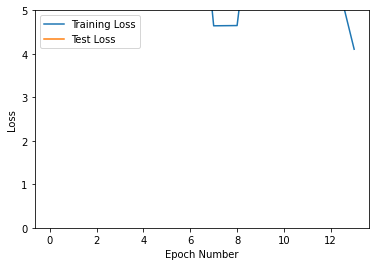

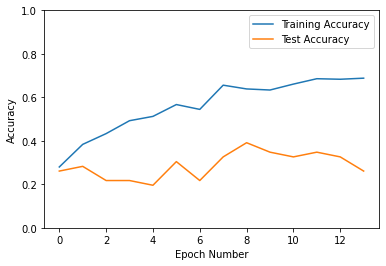

In [59]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, MLP_6_3, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

Looking at the scale of the abscissa, we can see that the weight becomes smaller, which means that the weight decay weakens the importance of some features, thus making the test accuracy a little higher (6.5217% higher than the model accuracy of `6.2` model).

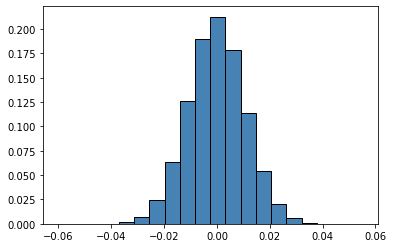

In [60]:
weight_plot(trained_model, model_name)

### 6.4 Multi-layer with kaiming weight initialization and weight decay. Using genetic algorithm to update weight instead of gradient descend to aovid gradient disappear.

Gradients in deep neural networks are unstable and either vanish or explode in hidden layers close to the input layer. This instability is the fundamental problem of gradient-based learning in deep neural networks. The root cause of gradient instability: The gradient on the previous layer is the product of the gradient from the later layer. When there are too many layers, gradient instability scenarios such as vanishing gradients and exploding gradients occur.

The weight update by genetic algorithm can effectively solve the problem of gradient disappearance. However, the genetic algorithm is essentially a group evolutionary algorithm, which means that each individual needs to train the model repeatedly, which increases the training time. In our Project, we only use one batch for training for simplicity.

**References**:
* [An improved RCSA-ANN model for the prediction of offshore short-term wind speed](http://html.rhhz.net/KQDLXXB/2022-04-110.htm)
* [PyGAD: An Intuitive Genetic Algorithm Python Library](https://arxiv.org/abs/2106.06158)

In [61]:
!pip3 install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import pygad.torchga as torchga
import pygad

In [63]:
model_name = 'MLP/6_4'
model_save_path = os.path.join('./Models', model_name)
    
hidden_size_GA = 64
# hidden_size_GA = hidden_size
MLP_6_4 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(fc_inputs, hidden_size_GA),
    nn.BatchNorm1d(hidden_size_GA),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(hidden_size_GA, hidden_size_GA),
    nn.BatchNorm1d(hidden_size_GA),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(hidden_size_GA, classes_num),
)
MLP_6_4 = MLP_6_4.to(device)

# summary(MLP_6_4, (fc_inputs,))
display_num_param(MLP_6_4)

There are 2413253 (2.41 million) parameters in this neural network


In [64]:
def fitness_func(solution, sol_idx):
    global train_label_GA, train_input_GA, torch_ga, MLP_6_4, loss_func
    """
    - model
    - solution
    - data
    """
    train_loss = 0.0

    inputs = train_input_GA.to(device)
    labels = train_label_GA.to(device)

    predictions = torchga.predict(model=MLP_6_4, solution=solution, data=inputs)
    train_loss += loss_func(predictions, labels).cpu().detach().numpy() * inputs.size(0)

    gc.collect()

    avg_train_loss = train_loss/len(labels)
    solution_fitness = 1.0 / (avg_train_loss + 0.00000001)

    return solution_fitness

def callback_generation(ga_instance):
    global test_label_GA, test_input_GA
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        MLP_6_4.eval()

        inputs = test_input_GA.to(device)
        labels = test_label_GA.to(device)

        predictions = pygad.torchga.predict(model=MLP_6_4, solution=solution, data=inputs)
        test_loss += loss_func(predictions, labels).cpu().detach().numpy() * inputs.size(0)

        ret, predictions = torch.max(predictions.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        test_acc += acc.item() * inputs.size(0)

        gc.collect()

    avg_test_loss = test_loss/len(labels)
    avg_test_acc = test_acc/len(labels)

    print("Absolute Error on test dataset: {:.4f}".format(avg_test_loss))
    print("Accuracy on test dataset: {:.4f}%".format(avg_test_acc*100))
    print()
    MLP_6_4.train()

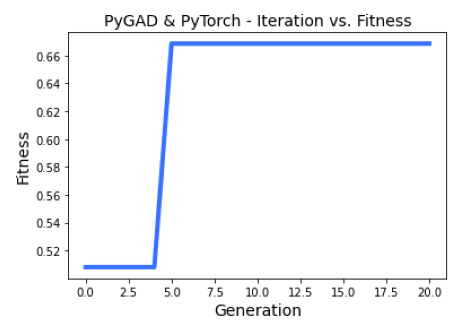

In [65]:
for i, (inputs, labels) in enumerate(train_loader):
    train_label_GA = labels
    train_input_GA = inputs
    break
for i, (inputs, labels) in enumerate(test_loader):
    test_label_GA = labels
    test_input_GA = inputs
    break


if model_retrain_flag:
    # Inialize pygad.torchga.TorchGA 
    torch_ga = torchga.TorchGA(model=MLP_6_4, num_solutions=20)

    num_generations = 20 if num_epochs>20 else num_epochs
    num_parents_mating = 10 
    initial_population = torch_ga.population_weights # Initialize weights

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        on_generation=callback_generation)

    ga_instance.run()

    if not os.path.exists(os.path.join('./Figure/Models', model_name)):
        os.makedirs(os.path.join('./Figure/Models', model_name))
        print(f"We create new directory {os.path.join('./Figure/Models', model_name)}")
    ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4, save_dir=os.path.join('./Figure/Models', model_name, 'Fitness value.png'))

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
        print(f"We create new directory {model_save_path}")
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    ga_instance = {'solution':solution, 'solution_fitness':solution_fitness, 'solution_idx':solution_idx}
    torch.save(ga_instance, os.path.join(model_save_path, 'garbage_classification_model.pt'))
else:
    ga_instance = torch.load(os.path.join(model_save_path, 'garbage_classification_model.pt'), map_location=torch.device('cpu'))
    solution, solution_fitness, solution_idx = ga_instance["solution"], ga_instance['solution_fitness'], ga_instance['solution_idx']

    picture_name = os.path.join('./Figure/Models', model_name, 'Fitness value.png')
    img = Image.open(picture_name)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
# print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

In [66]:
test_loss = 0.0
test_acc = 0.0
train_loss = 0.0
train_acc = 0.0

with torch.no_grad():
    MLP_6_4.eval()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = pygad.torchga.predict(model=MLP_6_4, solution=solution, data=inputs)
        train_loss += loss_func(predictions, labels).cpu().detach().numpy() * inputs.size(0)

        ret, predictions = torch.max(predictions.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * inputs.size(0)


    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = pygad.torchga.predict(model=MLP_6_4, solution=solution, data=inputs)
        test_loss += loss_func(predictions, labels).cpu().detach().numpy() * inputs.size(0)

        ret, predictions = torch.max(predictions.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        test_acc += acc.item() * inputs.size(0)

avg_train_loss = train_loss/len(train_loader.dataset)
avg_train_acc = train_acc/len(train_loader.dataset)
avg_test_loss = test_loss/len(test_loader.dataset)
avg_test_acc = test_acc/len(test_loader.dataset)

print("Absolute Error on train dataset: {:.4f}".format(avg_train_loss))
print("Accuracy on train dataset: {:.4f}%".format(avg_train_acc*100))
print("Absolute Error on test dataset: {:.4f}".format(avg_test_loss))
print("Accuracy on test dataset: {:.4f}%".format(avg_test_acc*100))

history = np.array([[20 if math.isnan(avg_train_loss) else avg_train_loss, 20 if math.isnan(avg_test_loss) else avg_test_loss, avg_train_acc, avg_test_acc]])
model_dict[model_name] = {'model': ga_instance, 'history': history}

Absolute Error on train dataset: 53.7532
Accuracy on train dataset: 17.3267%
Absolute Error on test dataset: 45.5655
Accuracy on test dataset: 19.5652%


Different from the first three models, the weights obtained by the genetic algorithm are beyond the range of $[-1, 1]$. And the proportion of weights close to 0 is more obvious than the first three models. Also, the accuracy of the model may not be high due to inadequate training.

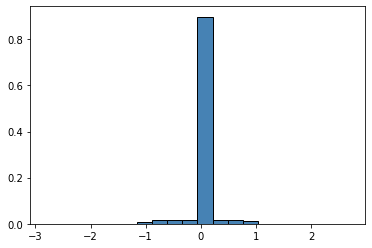

In [67]:
weight_plot(solution, model_name)

### Section summary

In [68]:
model_type = 'MLP'
bar_data_MLP = dict()

In [69]:
for model_name, value in model_dict.items():
    if not model_name.startswith(model_type):
        continue
    history = value['history']
    index_highest_accuracy_test = np.argmax(history[:, -1], axis=-1)
    train_loss, test_loss, train_accuracy, test_accuracy = history[index_highest_accuracy_test, :]
    bar_data_MLP[model_name] = (train_loss, test_loss, train_accuracy, test_accuracy)

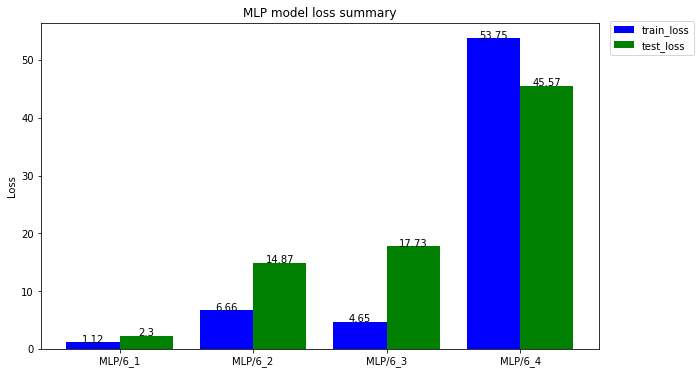

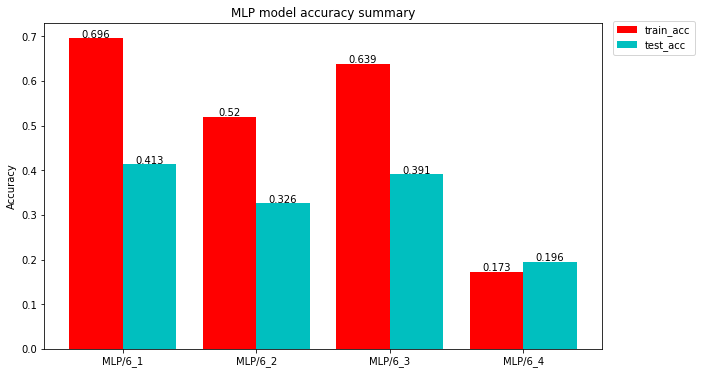

In [70]:
bar_plot(bar_data_MLP, model_type)

From the comparison between different models, the best baseline model is the model in `6.1`. The introduction of kaiming initialization and weight decay inhibits the improvement of model accuracy (whether it is a training set or a test set). Also, the best MLP model only obtains ~40% accuracy on test dataset, which is unsatisfactory.

## Step 7: CNN

* In this part, we build seven types of CNN models.
    1. Single-layer model
    2. Single-block (Inception)
    3. Single-block (Bottle Neck + Inception)
    4. Single-block (Resnet)
    5. Single-block (Resnet + Senet)
    6. Multi-block (Bottle Neck + Inception + Resnet + Senet)
    7. Multi-block (Pre-trained Resnet18)

In [71]:
hidden_size = 128
fc_inputs = (3, crop_size, crop_size)

### 7.1 Single-layer CNN (One Conv2d)

Train a base CNN model for reference.

In [72]:
model_name = 'CNN/7_1'

CNN_7_1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(128, classes_num),
)
CNN_7_1 = CNN_7_1.to(device)

weight_initialization(CNN_7_1)

optimizer = optim.Adam(CNN_7_1.parameters())

# summary(CNN_7_1, (3, crop_size, crop_size))
display_num_param(CNN_7_1)

There are 4229 (0.00 million) parameters in this neural network


Best Accuracy for test : 47.8261%, best loss: 1.4275
Accuracy for train : 40.3465%, loss: 1.3569


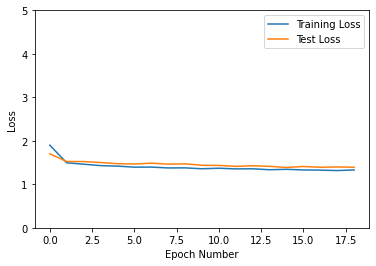

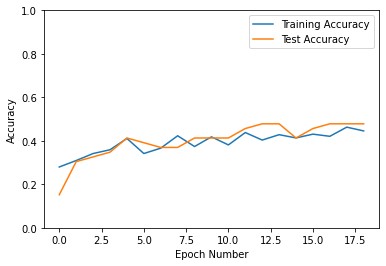

In [73]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, CNN_7_1, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

Despite properties such as translation invariance, it seems that a simple CNN model (47.8261%) does not perform much better than an MLP model (`6.1`: 41.3043%). But we need to note that the single-layer CNN model has only 4229 parameters, while the MLP model of similar accuracy requires 4834181 parameters, which is ~1150 times.

### 7.2 Single-block CNN (Inception Structure)
The traditional stacked network is basically a stack of convolutional layers, each layer only uses a convolution kernel of one size. For example, a large number of $3 × 3$ convolutional layers are used in the VGG structure. In fact, the feature map of the same layer can use multiple convolution kernels of different sizes to obtain features of different scales, and then combine these features to obtain better features than those using a single convolution kernel.

**References**:
* [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
* [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
* [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567)
* [Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/pdf/1602.07261.pdf)

In [74]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return nn.functional.avg_pool2d(x, kernel_size=x.size()[2:])

class Inception(nn.Module):
    def __init__(self,in_c,c1,c2,c3,c4):
        super(Inception,self).__init__()
        # -----------------------------------------
        self.p1 = nn.Sequential(
            nn.Conv2d(in_c,c1,kernel_size=1),
            nn.ReLU()
        )
        # -----------------------------------------
        self.p2 = nn.Sequential(
            nn.Conv2d(in_c,c2[0],kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c2[0], c2[1], kernel_size=3,padding=1),
            nn.ReLU()
        )
        # -----------------------------------------
        self.p3 = nn.Sequential(
            nn.Conv2d(in_c, c3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c3[0], c3[1], kernel_size=5,padding=2),
            nn.ReLU()
        )
        # -----------------------------------------
        self.p4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_c,c4,kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(x)
        p3 = self.p3(x)
        p4 = self.p4(x)
        return torch.cat((p1,p2,p3,p4),dim=1)

In [75]:
model_name = 'CNN/7_2'

CNN_7_2 = nn.Sequential(
    nn.Conv2d(3,hidden_size,kernel_size=7,stride=2,padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    # -----------------------------------------
    Inception(hidden_size,64,(96,128),(16,32),32),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    GlobalAvgPool2d(),
    # -----------------------------------------
    nn.Flatten(),
    nn.Linear(256, classes_num),
)
CNN_7_2 = CNN_7_2.to(device)

weight_initialization(CNN_7_2)

optimizer = optim.Adam(CNN_7_2.parameters())

# summary(CNN_7_2, (3, crop_size, crop_size))
display_num_param(CNN_7_2)

There are 170613 (0.17 million) parameters in this neural network


Best Accuracy for test : 56.5217%, best loss: 1.3612
Accuracy for train : 54.2079%, loss: 1.1416


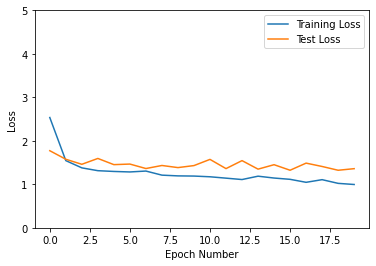

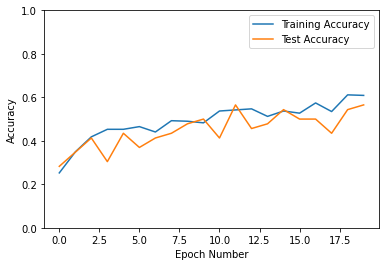

In [76]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, CNN_7_2, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

By introducing the Inception structure, the accuracy of the model is improved from 47.8261% to 56.5217%, which seems very satisfying. But we need to note that the parameters of the model have increased from the original 4229 to 170613, which is about 40 times. This cost is not always acceptable, and we need to find ways to maintain accuracy and reduce memory usage.

### 7.3 Single-block CNN (Bottle Neck+Inception Structure)
If only introducing convolution kernels of multiple sizes, it will bring a lot of extra parameters. In order to solve this problem, some 1×1 convolution kernels can be added to the Inception structure.

**References**: [Efficient Processing of Deep Neural Networks: A Tutorial and Survey Vivienne Sze](https://ieeexplore.ieee.org/abstract/document/8114708)

In [77]:
class Bottleneck_Inception(nn.Module):

    def __init__(self, block, in_channel, layer1_size, layer2_size, layer3_size, stride=1):
        super(Bottleneck_Inception, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        # -----------------------------------------
        self.layer1 = nn.Conv2d(in_channels=in_channel, out_channels=layer1_size,
                               kernel_size=1, stride=1)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(layer1_size)
        # -----------------------------------------
        self.layer2 = block
        self.bn2 = nn.BatchNorm2d(layer2_size)
        # -----------------------------------------
        self.layer3 = nn.Conv2d(in_channels=layer2_size, out_channels=layer3_size,
                               kernel_size=1, stride=1)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(layer3_size)
        # -----------------------------------------

        self.layers_1 = nn.Sequential(
            self.layer1,
            self.bn1,
            self.relu,
            )
        self.layers_2 = nn.Sequential(
            self.layer2,
            self.bn2,
            self.relu,
            )
        self.layers_3 = nn.Sequential(
            self.layer3,
            self.bn3,
            self.relu
            )

    def forward(self, x):
        out = self.layers_1(x)
        # print(out.shape)
        out = self.layers_2(out)
        # print(out.shape)
        out = self.layers_3(out)
        # print(out.shape)
        return out

In [78]:
model_name = 'CNN/7_3'

CNN_7_3 = nn.Sequential(
    nn.Conv2d(3,hidden_size,kernel_size=7,stride=2,padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    # -----------------------------------------
    Bottleneck_Inception(Inception(hidden_size,16,(24,32),(4,8),8), 128, 128, 64, 256),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    GlobalAvgPool2d(),
    # -----------------------------------------
    nn.Flatten(),
    nn.Linear(256, classes_num),
)
CNN_7_3 = CNN_7_3.to(device)

weight_initialization(CNN_7_3)

optimizer = optim.Adam(CNN_7_3.parameters())

# summary(CNN_7_3, (3, crop_size, crop_size))
display_num_param(CNN_7_3)

There are 68737 (0.07 million) parameters in this neural network


Best Accuracy for test : 56.5217%, best loss: 1.2888
Accuracy for train : 50.0000%, loss: 1.2019


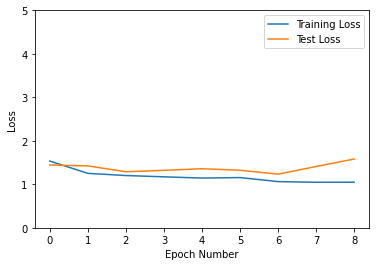

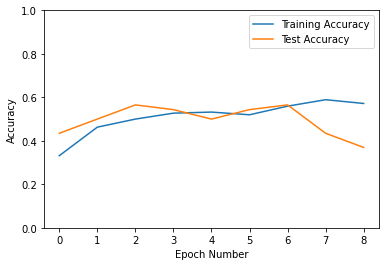

In [79]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, CNN_7_3, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

By introducing Bottle Neck, the accuracy of the model is still 56.5217%. But the number of parameters was reduced from 170613 to 68737, saving more than 50% of memory usage. However, the Inception structure only extends the model in the width direction. We need to find another structure so that the network can expand in the depth direction to obtain better results.

### 7.4 Single-block CNN (Resnet)
The traditional convolutional layer stacking network encounters a problem. When the number of layers is deepened, the performance of the network becomes worse and worse, largely because when the number of layers is deepened, the gradient dissipates more and more seriously. As for backpropagation, it is difficult to train shallow networks. To solve this problem, Resnet adds the input to output and makes it easier for gradients to flow into shallow networks.

**References**: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [80]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # -----------------------------------------
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # -----------------------------------------
        self.relu = nn.ReLU(inplace=True)

    def forward(self, input):
        identity = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += identity
        x = self.relu(x)
        return x

In [81]:
model_name = 'CNN/7_4'

CNN_7_4 = nn.Sequential(
    nn.Conv2d(3,hidden_size,kernel_size=7,stride=2,padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    # -----------------------------------------
    ResidualBlock(128, 128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    GlobalAvgPool2d(),
    # -----------------------------------------
    nn.Flatten(),
    nn.Linear(128, classes_num),
)
CNN_7_4 = CNN_7_4.to(device)

weight_initialization(CNN_7_4)

optimizer = optim.Adam(CNN_7_4.parameters())

# summary(CNN_7_4, (3, crop_size, crop_size))
display_num_param(CNN_7_4)

There are 315013 (0.32 million) parameters in this neural network


Best Accuracy for test : 56.5217%, best loss: 1.1360
Accuracy for train : 55.4455%, loss: 1.0409


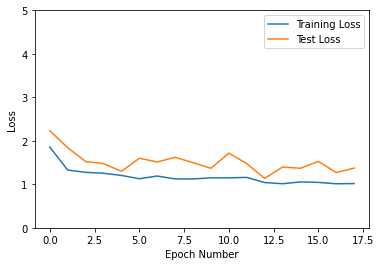

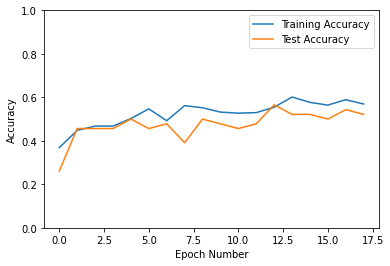

In [82]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, CNN_7_4, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

The accuracy of single Resnet block is still 56.5217%. But it is believed that through effective stacking, higher precision can be obtained. So later we will use the pre-trained Resnet18 to validate the guess.

### 7.5 Single-block CNN (Resnet+Senet)
Considering the relationship between different channels of features, for feature maps, among a large number of channels, the feature maps of some channels may be useful and some are invalid. The idea of Senet is to obtain the importance of each feature channel by learning. Then, according to this importance, useful features are promoted and invalid features are suppressed. The idea is similar to adding attention to different channels.

**References**: [Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

In [83]:
class SeBlock(nn.Module):
    def __init__(self, in_channels, output_channels, stride=1, is_1x1conv=False):
        super(SeBlock, self).__init__()
        self.is_1x1conv = is_1x1conv
        self.relu = nn.ReLU(inplace=True)

        # -----------------------------------------
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, output_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
        # -----------------------------------------
        if is_1x1conv:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(output_channels, output_channels//16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(output_channels//16, output_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_shortcut = x
        x = self.conv(x)
        seResult = self.se(x)
        x = seResult*x
        if self.is_1x1conv:
            x_shortcut = self.shortcut(x_shortcut)
        x = x + x_shortcut
        output = self.relu(x)
        return output

In [84]:
model_name = 'CNN/7_5'

CNN_7_5 = nn.Sequential(
    nn.Conv2d(3,hidden_size,kernel_size=7,stride=2,padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    SeBlock(128, 128, stride=1, is_1x1conv=True),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    GlobalAvgPool2d(),
    nn.Flatten(),
    nn.Linear(128, classes_num),
)
CNN_7_5 = CNN_7_5.to(device)

weight_initialization(CNN_7_5)

optimizer = optim.Adam(CNN_7_5.parameters())

# summary(CNN_7_5, (3, crop_size, crop_size))
display_num_param(CNN_7_5)

There are 55053 (0.06 million) parameters in this neural network


Best Accuracy for test : 63.0435%, best loss: 1.2674
Accuracy for train : 53.7129%, loss: 1.1064


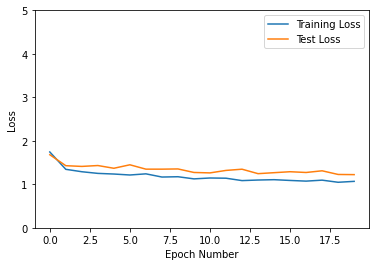

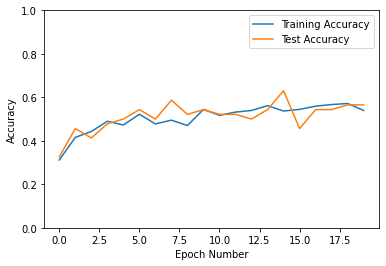

In [85]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, CNN_7_5, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

Through adding Senet structure into single Resnet blcok, the accuracy increas from 56.5217% to 63.0435%. But the number of parameters increases to 55053, which is similar to that of the single-block model with Bottle Neck & Inception structure. Then, we try to combine these four structure together to build a big model with less parameters and higher accuracy.

### 7.6 Multi-block CNN (Bottle Neck+Inception+Resnet+Senet)

In [86]:
class Inception_BottleNeck_Resnet_SenetModel(nn.Module):
    def __init__(self, is_1x1conv=False):
        super(Inception_BottleNeck_Resnet_SenetModel,self).__init__()
        self.is_1x1conv = is_1x1conv
        # -----------------------------------------
        self.b1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
        # -----------------------------------------
        self.b2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=1),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        # -----------------------------------------
        self.se1 = SeBlock(128, 128, stride=1, is_1x1conv=self.is_1x1conv)
        # -----------------------------------------
        self.b3 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
        # -----------------------------------------
        self.se2 = nn.Sequential(
            SeBlock(128, 128, stride=1, is_1x1conv=self.is_1x1conv),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
        # -----------------------------------------
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        # -----------------------------------------
        self.b4 = nn.Sequential(
            Bottleneck_Inception(Inception(256,128,(96,128),(16,32),32), 256, 256, 320, 1024),
            GlobalAvgPool2d()
        )
        # -----------------------------------------
        self.fc = nn.Sequential(
            nn.Linear(1024, classes_num)
        )
        # -----------------------------------------

    def forward(self, x):
        x = self.b1(x)
        x_shortcut = x
        x = self.b2(x)
        se1_result = self.se1(x)
        x = self.b3(se1_result)
        x = self.se2(x)
        
        x = self.upsample(x)
        x = self.upsample(x)
        x = torch.concat((x, se1_result), dim=1)
        x = self.b4(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [87]:
model_name = 'CNN/7_6'

CNN_7_6 = Inception_BottleNeck_Resnet_SenetModel(is_1x1conv=True)
CNN_7_6 = CNN_7_6.to(device)

weight_initialization(CNN_7_6)

optimizer = optim.Adam(CNN_7_6.parameters())

# summary(CNN_7_6, (3, crop_size, crop_size))
display_num_param(CNN_7_6)

There are 903429 (0.90 million) parameters in this neural network


Best Accuracy for test : 65.2174%, best loss: 1.0371
Accuracy for train : 71.7822%, loss: 0.7498


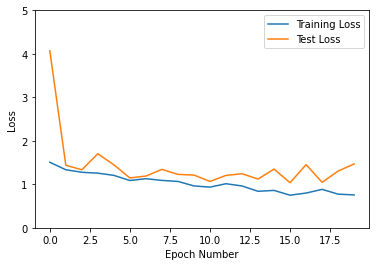

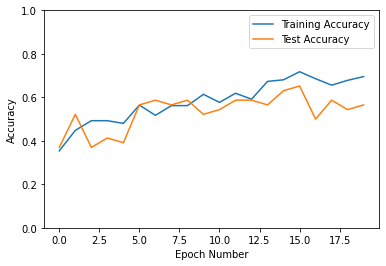

In [88]:
if model_retrain_flag:
    trained_model, history = train_and_test(train_loader, test_loader, CNN_7_6, model_name, loss_func, optimizer, device, num_epochs)
    history_save(history, model_name)

    history = np.array(history)
    result_figure_save(history, model_name)
else:
    trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

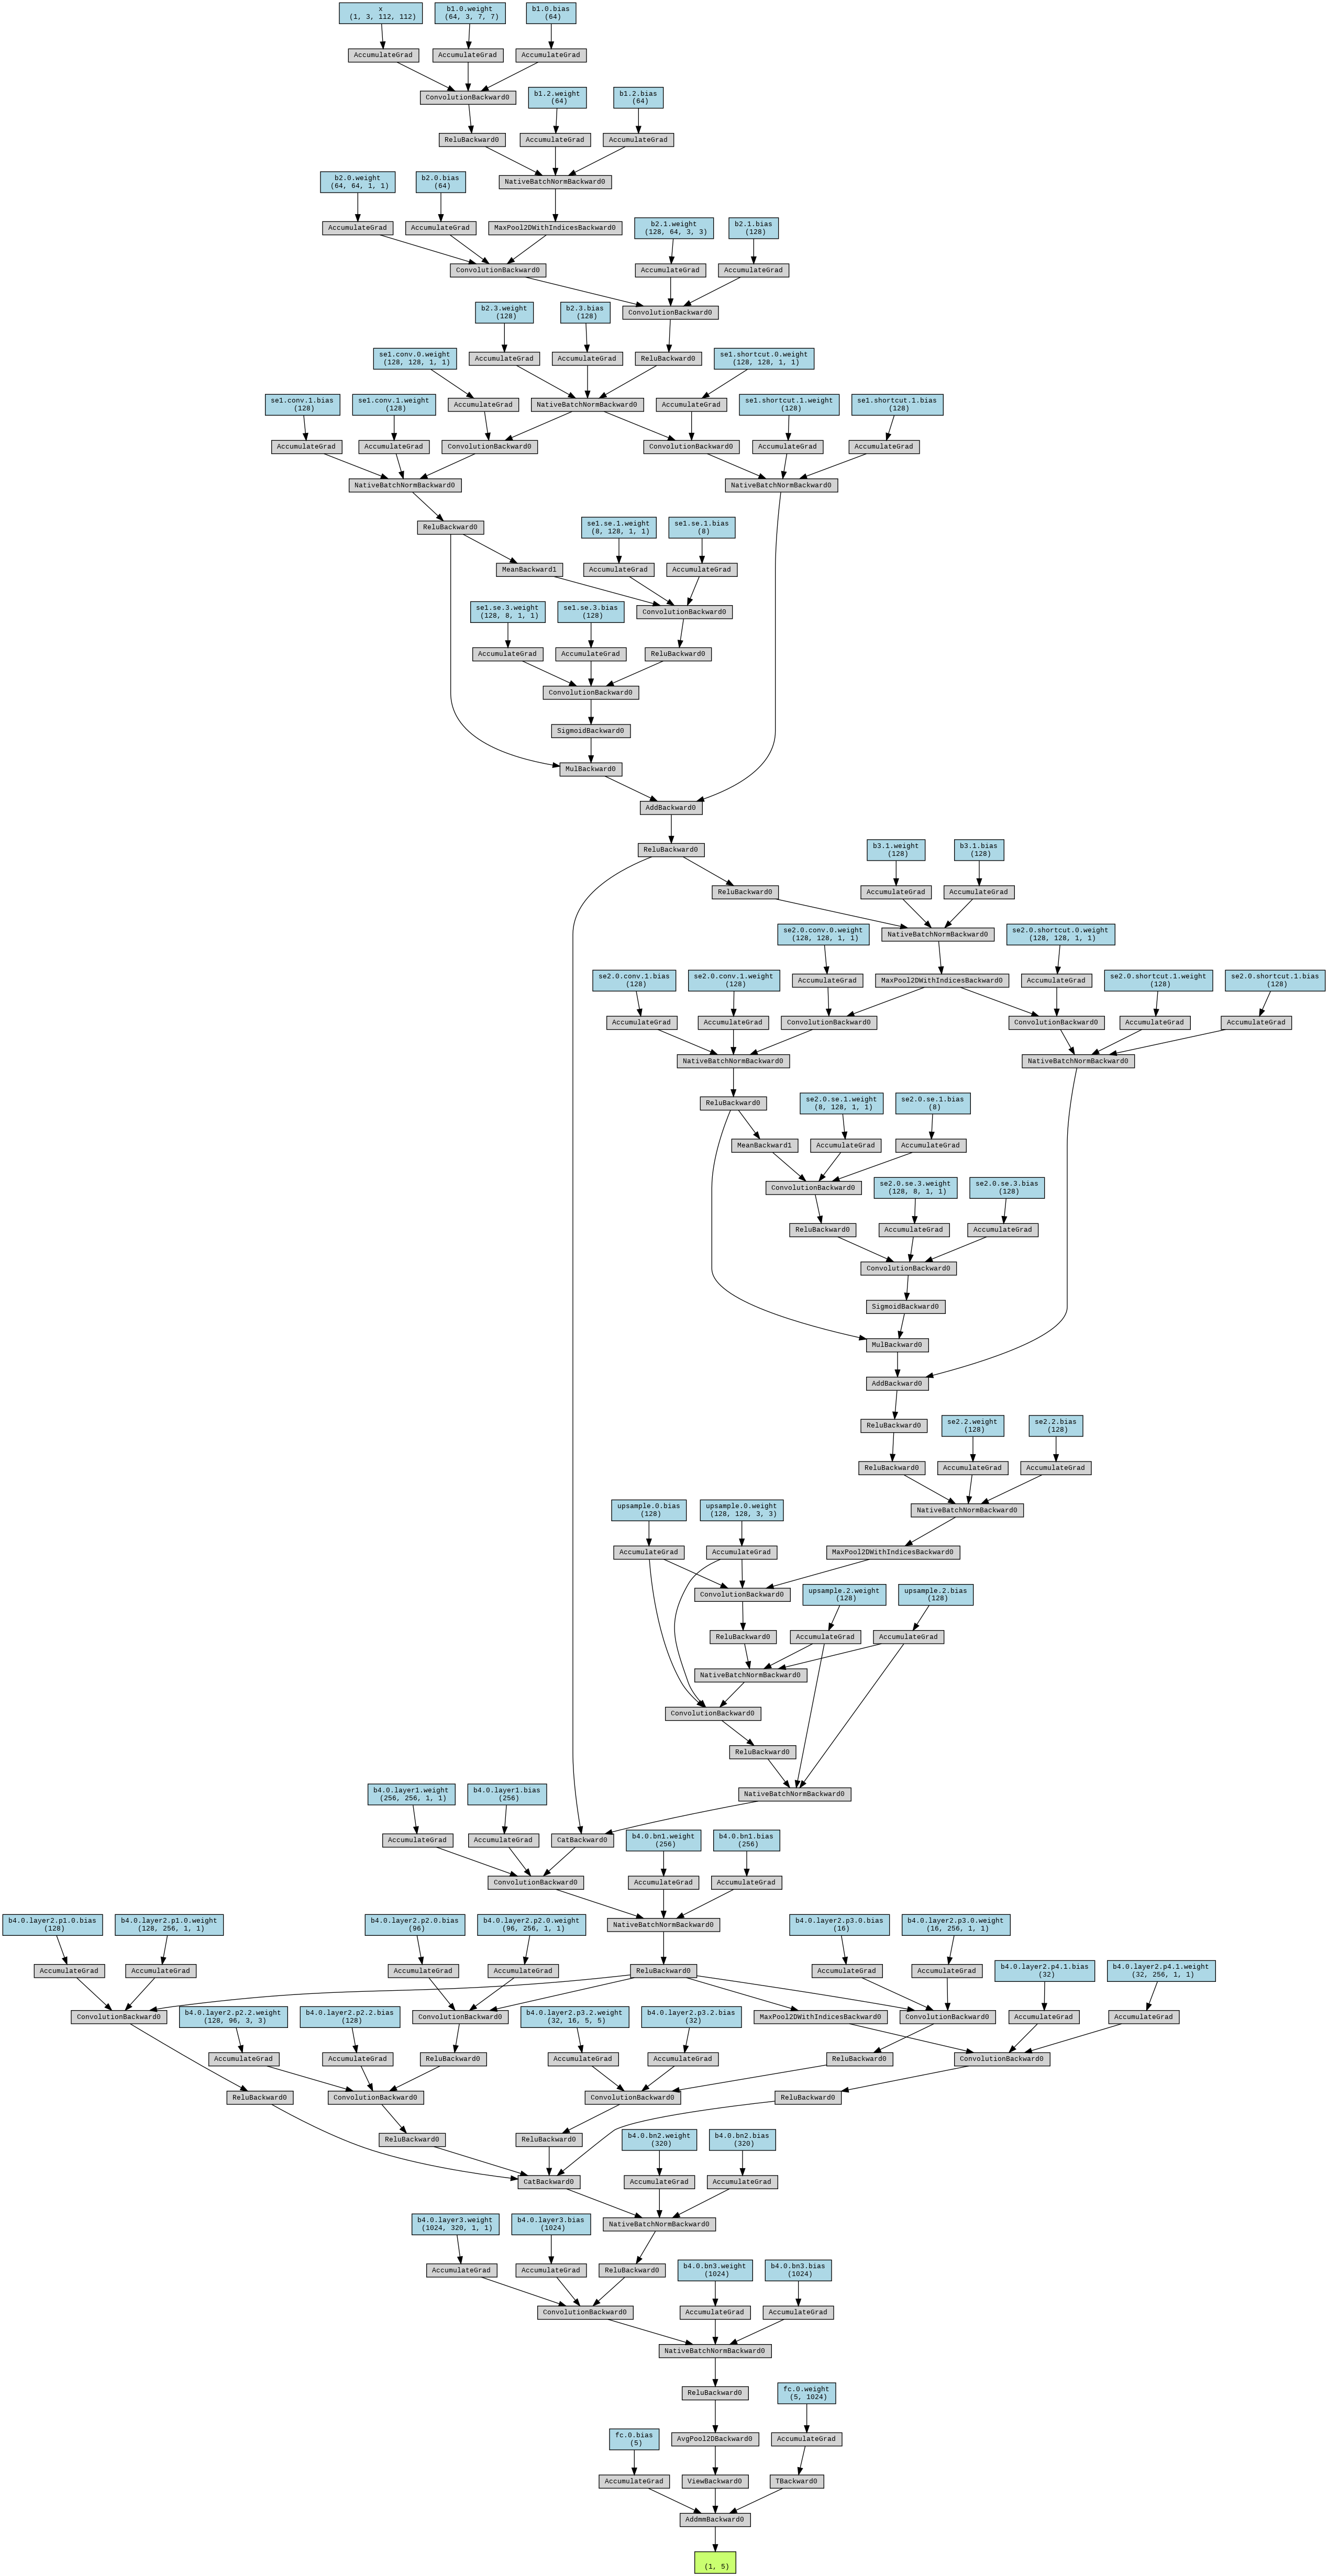

In [89]:
model_structure_plot(CNN_7_6, model_name, crop_size=crop_size, folder_name='CNN')

### 7.7 Multi-block CNN  (Pre-trained Resnet18)
**References:** [Aggregated Residual Transformations for Deep Neural Networks](https://https://arxiv.org/pdf/1611.05431.pdf)

In [90]:
from torchvision.models import ResNet18_Weights
model_name = 'CNN/resnet18'


resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

for param in resnet18.parameters():
    param.requires_grad = False
fc_inputs = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_inputs, classes_num)
resnet18 = resnet18.to(device)

optimizer = optim.Adam(resnet18.parameters())

# summary(resnet18, (3, crop_size, crop_size))
display_num_param(resnet18)

There are 11179077 (11.18 million) parameters in this neural network


Best Accuracy for test : 86.9565%, best loss: 0.4771
Accuracy for train : 78.7129%, loss: 0.5875


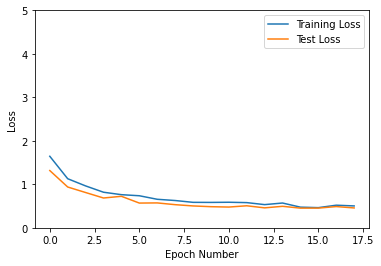

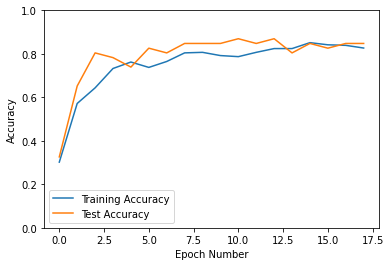

In [91]:
if model_retrain_flag:
  trained_model, history = train_and_test(train_loader, test_loader, resnet18, model_name, loss_func, optimizer, device, num_epochs)
  history_save(history, model_name)

  history = np.array(history)
  result_figure_save(history, model_name)
else:
  trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

In [92]:
resnet18 = trained_model

### Section summary

In [93]:
model_type = 'CNN'
bar_data_CNN = dict()

In [94]:
for model_name, value in model_dict.items():
    if not model_name.startswith(model_type):
        continue
    history = value['history']
    index_highest_accuracy_test = np.argmax(history[:, -1], axis=-1)
    train_loss, test_loss, train_accuracy, test_accuracy = history[index_highest_accuracy_test, :]
    bar_data_CNN[model_name] = (train_loss, test_loss, train_accuracy, test_accuracy)

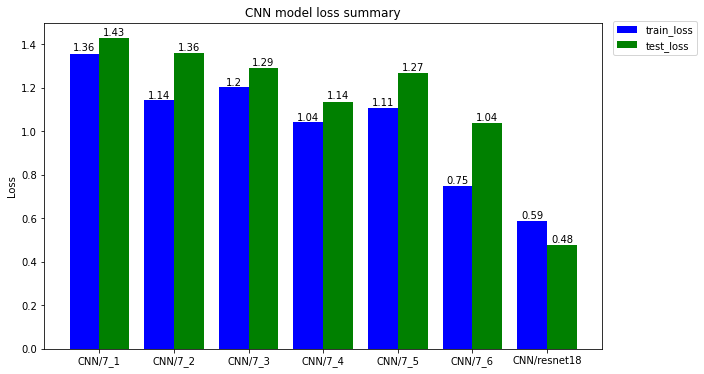

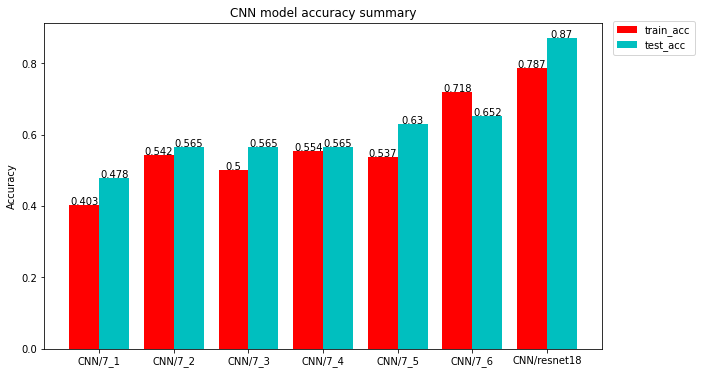

In [95]:
bar_plot(bar_data_CNN, model_type)

* We have trained seven different models. Compared to the basic one `CNN/7_1`, other models have certain performance improvements. The **resnet18** model using **transfer learning** achieved the highest accuracy of **0.87** on the test dataset.
* We extend the model in both width and depth directions:
    * **Width**: 
        * **Inception**(`CNN/7_2`): The information of different scales of the image is extracted through the multiple convolution kernel structures of Inception, and finally fused to obtain a better representation of the image.
        * **Bottleneck**(`CNN/7_3`): Since Inception uses multiple convolution kernels on one layer, there is no doubt that the parameters will be more than the basic model. Adding Bottleneck's 1x1 convolution kernel can alleviate this probelm. (This trick is also considered in many other structures to reduce the computation)
    * **Depth**:
        * **ResNet**(`CNN/7_4`): ResNet includes a residual branch and a short-cut branch, which is one more short-cut branch than the traditional convolutional structure, used to transmit low-level information so that the network can be trained deeply. Due to the shortcut layer, the weight update is performed in an additive manner, which alleviates problems such as gradient disappearance.
        * **SeNet**(`CNN/7_5`): Actually, this structure does not belong to the content of extending the model in the depth direction, but we combine it with ResNet and it is better to be explained in this section. SeNet improves the accuracy by modeling the correlation between feature channels and strengthening important features.
    * As can be seen from the results, except for the introduction of Bottleneck, the introduction of each trick can improve the performance on test dataset. (And introduction of Bottleneck helps us to reduce the memory usage)
* After we **incorporate these four tricks** into one model `CNN/7_6`, the high accuracy on the training set indicates that the model can better learn the features of the images. Also the performance on the test set also has a certain improvement. It is believed that with reasonable stacking and structural mixing, this model can perform better.
* Since exploring effective stacking or hybrid approaches requires a lot of effort, we chose **ResNet18** to simplify our research.
    * To obtain better performance, **transfer learning** is used in this model. Transfer learning focuses on storing solved models of existing problems and leveraging them on other different but related problems.
    * Model `CNN/resnet18` gets an accuracy of 0.87 on the test dataset, which is twice that of the most basic MLP model. It is proved to be a effective model in our research.

## Step 8: ANN

### 8.1 Nonlocal block enhanced ResNet18
After each resnet 18 block, we add a nonlocal block to enhance feature extraction.

In [96]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models

class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1



        conv_nd = nn.Conv2d
        max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
        bn = nn.BatchNorm2d


        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x, return_nl_map=False):
        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        if return_nl_map:
            return z, f_div_C
        return z




class NONLocalBlock2D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock2D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=2, sub_sample=sub_sample,
                                              bn_layer=bn_layer,)




class ResNet18_Non_Local(nn.Module):
    def __init__(self, classes_num, sub_sample=True, bn_layer=True):
        super(ResNet18_Non_Local, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.final_fc = nn.Linear(self.resnet18.fc.in_features, classes_num)
        self.non_local_block_1 = NONLocalBlock2D(64, sub_sample=sub_sample, bn_layer=bn_layer)
        self.non_local_block_2 = NONLocalBlock2D(128, sub_sample=sub_sample, bn_layer=bn_layer)
        self.non_local_block_3 = NONLocalBlock2D(256, sub_sample=sub_sample, bn_layer=bn_layer)
        self.non_local_block_4 = NONLocalBlock2D(512, sub_sample=sub_sample, bn_layer=bn_layer)
        self.set_param()

    def set_param(self):
        for param in self.resnet18.parameters():
            param.requires_grad = False

    def forward(self, x):

        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)
        
        x = self.resnet18.layer1(x)
        x = self.non_local_block_1(x)
        x = self.resnet18.layer2(x)
        x = self.non_local_block_2(x)
        x = self.resnet18.layer3(x)
        x = self.non_local_block_3(x)
        x = self.resnet18.layer4(x)
        x = self.non_local_block_4(x)
        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.final_fc(x)

        return x

In [97]:
model_name = 'ANN/RestNet18_nonlocal'
resnet18_nonlocal = ResNet18_Non_Local(classes_num)
resnet18_nonlocal = resnet18_nonlocal.to(device)
optimizer = optim.Adam(resnet18_nonlocal.parameters())
# summary(resnet18, (3, crop_size, crop_size))
display_num_param(resnet18_nonlocal)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


There are 12392717 (12.39 million) parameters in this neural network


Best Accuracy for test : 89.1304%, best loss: 0.4170
Accuracy for train : 88.6139%, loss: 0.3439


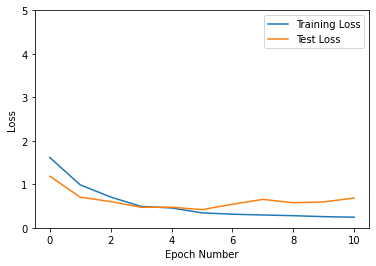

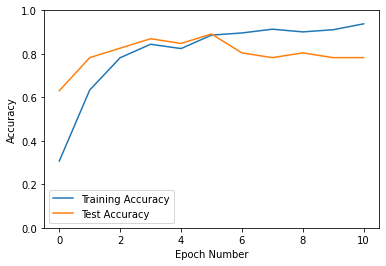

In [98]:
if model_retrain_flag:
  trained_model, history = train_and_test(train_loader, test_loader, resnet18_nonlocal, model_name, loss_func, optimizer, device, num_epochs)
  history_save(history, model_name)

  history = np.array(history)
  result_figure_save(history, model_name)

else:
  trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

### 8.2 Vision Transformer

In [99]:
#if resplit_dataset_flag:
input_size_vit = 256
crop_size_vit = 224
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=input_size_vit),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomResizedCrop(size=crop_size, scale=(0.8, 1.0)),
        transforms.CenterCrop(size=crop_size_vit),
        transforms.ToTensor(),
        transforms.Normalize(mean_RGB.tolist(), std_RGB.tolist())
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=input_size_vit),
        transforms.CenterCrop(size=crop_size_vit),
        transforms.ToTensor(),
        transforms.Normalize(mean_RGB.tolist(), std_RGB.tolist())
    ])
}


#load image data
data = {
    'train': datasets.ImageFolder(root=train_dataset_save_path, transform=image_transforms['train']),
    'test': datasets.ImageFolder(root=test_dataset_save_path, transform=image_transforms['test'])
}


train_data_size = len(data['train'])
test_data_size = len(data['test'])

train_loader_vit = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
test_loader_vit = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

classes = data['train'].class_to_idx
classes_num = len(data['train'].class_to_idx)

torch.save(train_loader, dataset_save_path + 'train_loader_vit.pt')
torch.save(test_loader, dataset_save_path + 'test_loader_vit.pt')
torch.save(classes, dataset_save_path + 'classes_vit.pt')
torch.save(image_transforms, dataset_save_path + 'transform_vit.pt')

In [100]:
from torchvision.models import vit_l_16
model_name = 'ANN/ViT'
vit = vit_l_16(pretrained=True)
for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Linear(vit.hidden_dim, classes_num)
vit = vit.to(device)
optimizer = optim.Adam(vit.parameters(), weight_decay=1)

display_num_param(vit)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


There are 303306757 (303.31 million) parameters in this neural network


Best Accuracy for test : 93.4783%, best loss: 0.5206
Accuracy for train : 95.5446%, loss: 0.4598


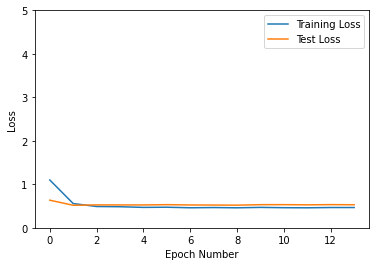

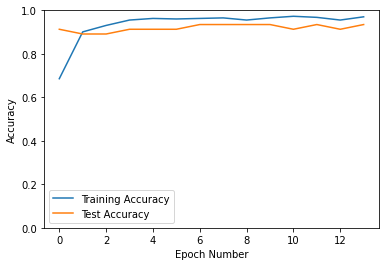

In [101]:
if model_retrain_flag:
  trained_model, history = train_and_test(train_loader_vit, test_loader_vit, vit, model_name, loss_func, optimizer, device, num_epochs)
  history_save(history, model_name)

  history = np.array(history)
  result_figure_save(history, model_name)

else:
  trained_model, history = model_load(model_name, device)

model_dict[model_name] = {'model': trained_model, 'history': history}

### Section summary

In [102]:
model_type = 'ANN'
bar_data_ANN = dict()

In [103]:
for model_name, value in model_dict.items():
    if not model_name.startswith(model_type):
        continue
    history = value['history']
    index_highest_accuracy_test = np.argmax(history[:, -1], axis=-1)
    train_loss, test_loss, train_accuracy, test_accuracy = history[index_highest_accuracy_test, :]
    bar_data_ANN[model_name] = (train_loss, test_loss, train_accuracy, test_accuracy)

As can be seen in the figure, with attention mechanism, the performance on training and test dataset is much better.

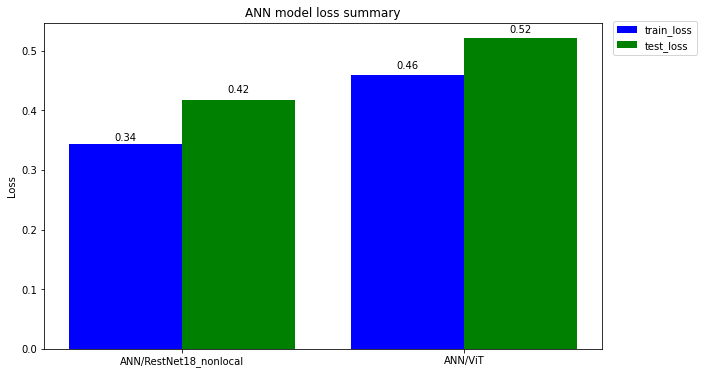

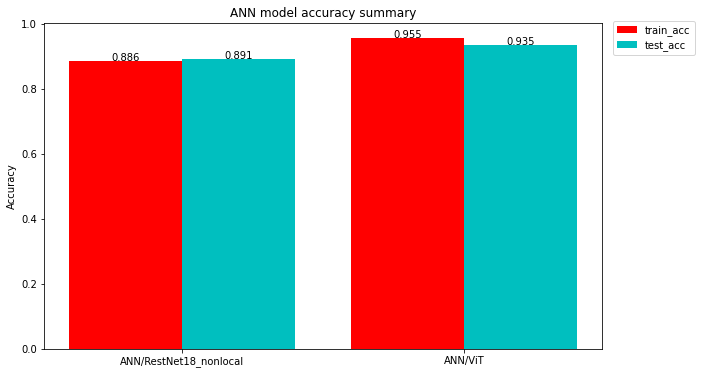

In [104]:
bar_plot(bar_data_ANN, model_type)

## Step 9: NN Interpretability (Class Activation Map)

#### The image and the heatmap that we want to show.

In [105]:
class_file_name = list(filter(lambda x: not x.endswith("csv"), os.listdir(test_dataset_save_path)))
import random
show_dir = []
for each_one in class_file_name:
  each_file = random.sample(os.listdir(os.path.join(test_dataset_save_path, each_one)), 1)

  for item in each_file:
    show_dir.append(os.path.join(test_dataset_save_path, each_one, item))
print(show_dir)

['./Dataset/test/Dry garbage_Pen/Pen_69.jpg', './Dataset/test/Harmful waste_Battery/Battery_55.jpg', './Dataset/test/Recyclable_Newspaper/Newspaper_34.jpg', './Dataset/test/Recyclable_Pillow/Pillow_38.jpg', './Dataset/test/Wet garbage_Vegetables/Vegetables_82.jpg']


In [106]:
model = copy.deepcopy(model_dict['CNN/resnet18']['model']).to(device)
_ = model.eval()

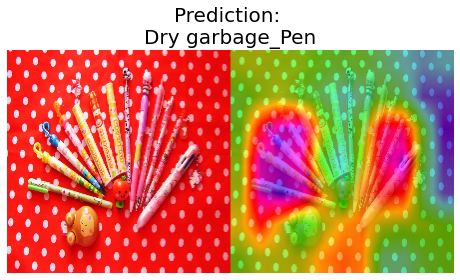

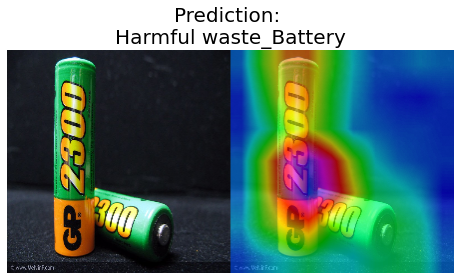

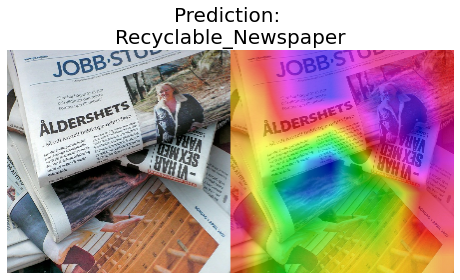

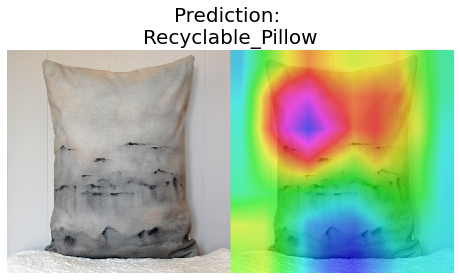

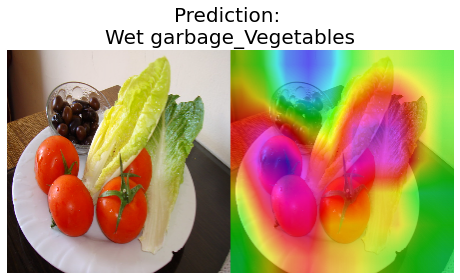

In [107]:
import numpy as np
from torchvision import models, transforms
import cv2
from PIL import Image
from torch.nn import functional as F


global feature_data
feature_data = []

def feature_hook(model, input, output):
    feature_data.append(output.cpu().data.numpy())

model._modules.get('layer4').register_forward_hook(feature_hook)
fc_weights_model = model._modules.get('fc').weight.cpu().data.numpy()

image_transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_RGB.tolist(), std_RGB.tolist())                  
])


def makeCAM(feature, weights, classes_id):
    # print(feature.shape, weights.shape, classes_id)

    bz, nc, h, w = feature.shape
    cam = weights[classes_id].dot(feature.reshape(nc, h * w))
    cam = cam.reshape(h, w) 
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam_gray = np.uint8(255 * cam)
    return cv2.resize(cam_gray, (224, 224))


def heat_map_cam(show_dir):
  images_so_far = 0
  for path_name_show in show_dir:
    image = image_transform(Image.open(path_name_show)).unsqueeze(0).to(device)
    out_model = model(image)
    predict_classes_id_model = np.argmax(F.softmax(out_model, dim=1).cpu().data.numpy())

    cam_gray_model = makeCAM(feature_data[0], fc_weights_model, predict_classes_id_model)

    src_image = cv2.resize(cv2.imread(path_name_show), (224, 224))[:, :, ::-1]
    h, w, _ = src_image.shape

    cam_color_model = cv2.applyColorMap(cv2.resize(cam_gray_model, (w, h)),
                                          cv2.COLORMAP_HSV)

    cam_model = src_image * 0.4 + cam_color_model * 0.6

    cam_hstack = np.hstack((src_image, cam_model))


    for class_name, class_index in classes.items():
        if class_index == predict_classes_id_model:
            title_name = class_name
            break

    fig = plt.figure(figsize=(8, 8))
    plt.title('Prediction: \n{}'.format(title_name), fontsize=20)
    plt.imshow(cam_hstack / 255.)
    plt.axis('off')
    feature_data.clear()

heat_map_cam(show_dir)

## Step 10: Visualization for more information

In [108]:
model = copy.deepcopy(model_dict['ANN/ViT']['model']).to(device)
_ = model.eval()
model_name = 'ANN/ViT' if isinstance(model, type(vit)) else 'Other_model'

### 10.1 Confusion Matrix

In the field of machine learning and statistical classification problems, confusion matrices are visualization tools, especially for supervised learning, and in unsupervised learning are generally called matching matrices. Each column of the matrix represents a predicted class instance, while each row represents an actual class instance. It is so named because this matrix makes it easy to see if the machine is confusing two different classes (for example, mistaking one for the other).

In [109]:
from sklearn.metrics import confusion_matrix
import itertools

In [110]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, folder_name='./Figure/Summary'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    figure_save_path = os.path.join(folder_name, 'All')
    if not os.path.exists(figure_save_path):
        os.makedirs(figure_save_path)
        print(f"We create new directory {figure_save_path}")

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=17)
    plt.yticks(tick_marks, classes, fontsize=17)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.savefig(os.path.join(figure_save_path, 'confusion matrix.png'))

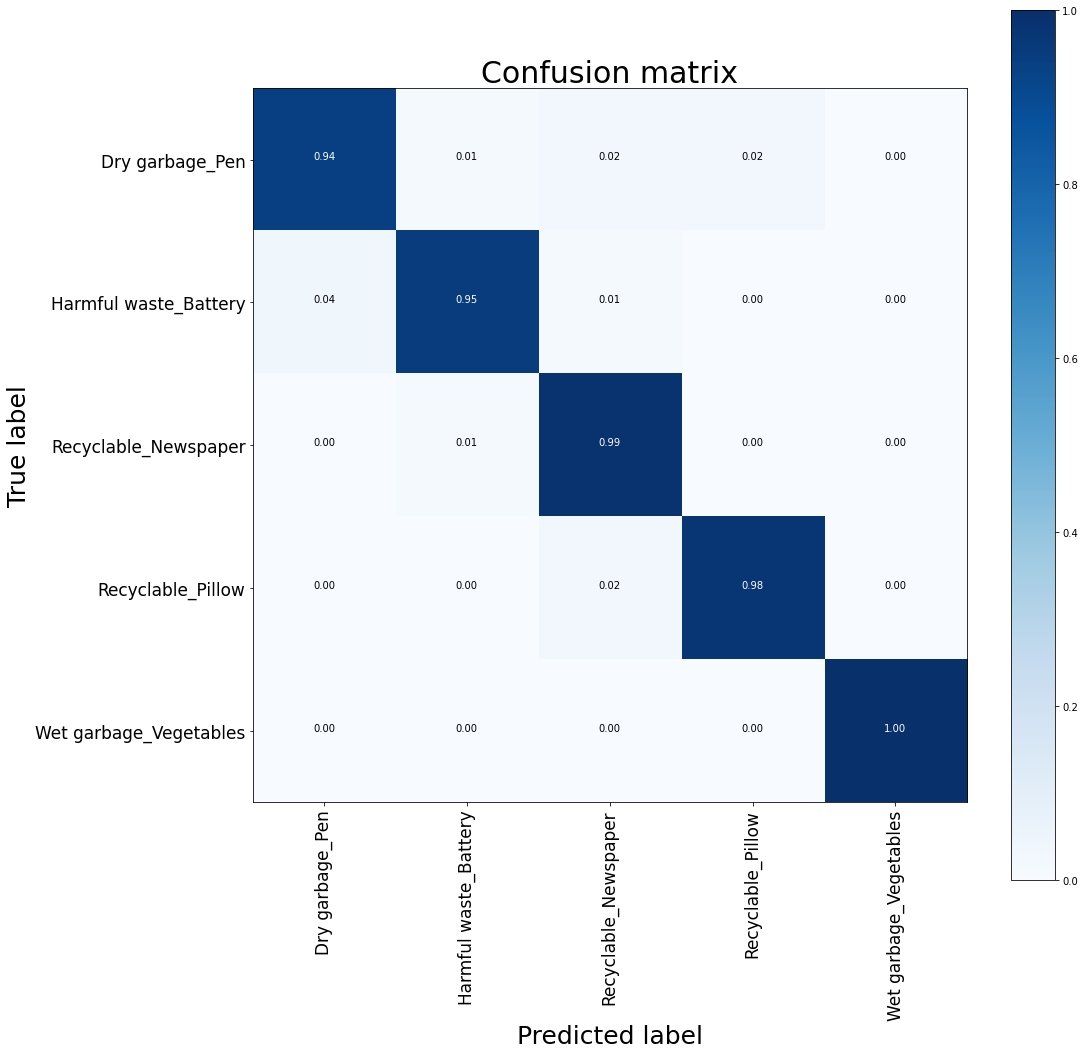

CPU times: user 18.4 s, sys: 536 ms, total: 19 s
Wall time: 19.4 s


In [111]:
%%time

truth_labels = []
predict_labels = []

with torch.no_grad():

    if 'ViT' in model_name:
        loader = train_loader_vit
    else:
        loader = train_loader

    for i, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = np.argmax(F.softmax(model(inputs), dim=1).cpu().data.numpy(), axis=1)
        truth_labels.extend(labels.cpu().detach().numpy().reshape(-1))
        predict_labels.extend(outputs.reshape(-1))

cnf_matrix = confusion_matrix(truth_labels, predict_labels)
plt.figure(figsize=(16,16))
plot_confusion_matrix(cnf_matrix, classes=classes, title="Confusion matrix")
plt.show()

### 10.2 t-SNE

t-SNE is a technology that integrates dimensionality reduction and visualization. It is based on the improvement of SNE visualization. It solves the characteristics of crowded sample distribution and indistinct boundaries after SNE visualization. It is currently the best dimensionality reduction visualization method.

**References**: [Visualizing Data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

In [112]:
from sklearn.manifold import TSNE

In [113]:
def tsne_plot(X, y, perplexity=None, palette=None):
    labels = y['label'].values
    if not palette:
       palette = sns.color_palette("bright", np.unique(labels).size)
    if not perplexity:
        tsne = TSNE()
    else:
        tsne = TSNE(perplexity=perplexity)
    X_embedded = tsne.fit_transform(X)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette)
    return X_embedded, palette

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


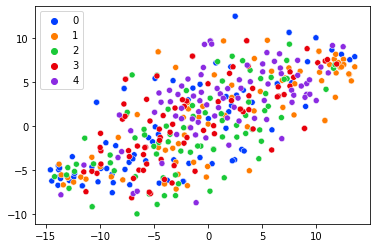

In [114]:
X_train_TSNE, y_train_TSNE, label_encoder_train = images_df(train_dataset_save_path)
X_embedded_train, _ = tsne_plot(X_train_TSNE, y_train_TSNE)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


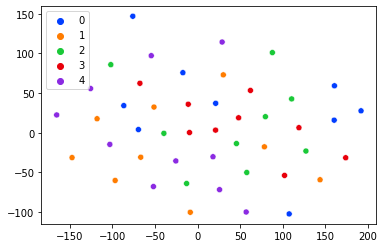

In [115]:
X_test_TSNE, y_test_TSNE, _ = images_df(test_dataset_save_path)
X_embedded_test, _ = tsne_plot(X_test_TSNE, y_test_TSNE)

As can be seen in the figures, it is quite hard to classify the images at low dimensions and no obvious clusters can be found.

### 10.3 Visualize by bokeh

* Bokeh is a Python library for creating interactive visualizations for modern web browsers. It helps you build beautiful graphics, ranging from simple plots to complex dashboards with streaming datasets.

* We use bokeh to visualize the predictions on our dataset.
    * We first reduce our data to 2 dimensions based on t-SNE. Then each point will be marked with the real label and the predicted label.
    * Through the slider, you can choose to view the data points belonging to a certain type of real label.
    * The keyword query provides a look at the data points that belong to a certain class of predicted labels.
* The result can also been reached by this link: [garbage_classification_plot_interactive](https://hewenbin-bobo.github.io/garbage_classification_plot_interactive.html)

In [116]:
from plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header, description_current, description_keyword, tasks_for_each_member
from call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout

#### Initial Setup

In [117]:
# show on notebook
output_notebook()

# target labels
truth_indexes = []
predict_indexes = []
X_TSNE = []

with torch.no_grad():
    model.eval()

    if 'ViT' in model_name:
        loader = train_loader_vit
    else:
        loader = train_loader

    for i, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = np.argmax(F.softmax(model(inputs), dim=1).cpu().data.numpy(), axis=1)
        truth_indexes.extend(labels.cpu().detach().numpy().reshape(-1))
        predict_indexes.extend(outputs.reshape(-1))
        X_TSNE.extend(inputs.cpu().detach().numpy().reshape(inputs.shape[0],-1))

    if 'ViT' in model_name:
        loader = test_loader_vit
    else:
        loader = test_loader
    
    for i, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = np.argmax(F.softmax(model(inputs), dim=1).cpu().data.numpy(), axis=1)
        truth_indexes.extend(labels.cpu().detach().numpy().reshape(-1))
        predict_indexes.extend(outputs.reshape(-1))
        X_TSNE.extend(inputs.cpu().detach().numpy().reshape(inputs.shape[0],-1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


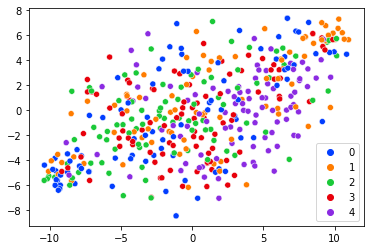

In [118]:
X_TSNE_df = pd.DataFrame(X_TSNE)
X_TSNE_df = X_TSNE_df.add_prefix('X')
truth_indexes_df = pd.DataFrame(truth_indexes, columns=['label'])
X_embedded, _ = tsne_plot(X_TSNE, truth_indexes_df)

In [119]:
classes_encoded = {index:label for label, index in classes.items()}
label_transformer = lambda x: classes_encoded.get(x, 'None')
label_transformer = np.vectorize(label_transformer)
truth_labels = label_transformer(truth_indexes)
predict_labels = label_transformer(predict_indexes)

In [120]:
keywords = {index:set() for index in classes.values()}
for truth_index, predict_label in zip(truth_indexes, predict_labels):
    keywords[truth_index].add(predict_label)
keywords = {index:", ".join(keyword) for index, keyword in keywords.items()}
print(keywords)

{0: 'Wet garbage_Vegetables, Recyclable_Pillow, Dry garbage_Pen, Recyclable_Newspaper', 1: 'Recyclable_Newspaper, Dry garbage_Pen, Harmful waste_Battery', 2: 'Wet garbage_Vegetables, Recyclable_Newspaper', 3: 'Recyclable_Pillow, Recyclable_Newspaper', 4: 'Wet garbage_Vegetables'}


In [121]:
classes_encoded = {index:label for label, index in classes.items()}
label_transformer = lambda x: classes_encoded.get(x, 'None')
label_transformer = np.vectorize(label_transformer)
truth_labels = label_transformer(truth_indexes)
predict_labels = label_transformer(predict_indexes)

# data sources
source = ColumnDataSource(data=dict(
    x = X_embedded[:,0],
    y = X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    indexes = truth_indexes, 
    truths = truth_labels,
    predictions = predict_labels,
    labels = truth_labels
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Truth", "@truths{safe}"),
    ("Prediction", "@predictions{safe}"),
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='indexes', 
                     palette=Category20[5],
                     low=min(truth_indexes) ,high=max(truth_indexes))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Garbage classification (Shanghai) with t-SNE and Deep Learning", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=10, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend_group='labels')
plot.legend.background_fill_alpha = 0.6

#### Widgets

In [122]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific class to see the keywords.', height=25)
input_callback_instance = input_callback(plot, source, text_banner, keywords, classes_num)

# currently selected image
div_curr = Div(text="""Click on a plot to see more information.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=len(classes), value=len(classes), step=1, title="Classes #")
slider.js_on_change('value', input_callback_instance)
keyword = TextInput(title="Search:")
keyword.js_on_change('value', input_callback_instance)

# RangesUpdate
# pass call back arguments
input_callback_instance.args["text"] = keyword
input_callback_instance.args["slider"] = slider

#### Style

In [123]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "stretch_width"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

tasks_for_each_member.sizing_mode = "stretch_width"
tasks_for_each_member.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
tasks_for_each_member.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

#### Show

In [124]:
# LAYOUT OF THE PAGE
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, tasks_for_each_member, notes],
])
l.sizing_mode = "scale_both"


# show
output_file('./garbage_classification_plot_interactive.html')
show(l)

### 10.4 Visualize by Gradio

* Since we want to solve the practical problem, we need to deploy the model to achieve online prediction. We deployed the model through Gradio and Hugging Face.

* The results can be reached through this link [CS5242-Project-Garbage-Classification-Shanghai (Gradio)](https://huggingface.co/spaces/wenbin1996/CS5242-Project-Garbage-Classification-Shanghai) in addition to being seen in this notebook.

In [125]:
def predict_image_upload(inputs):
    inputs = Image.fromarray(inputs.astype('uint8'), 'RGB')
    inputs = image_transforms['test'](inputs).unsqueeze(0).to(device) # 3D -> 4D (add batch_size=1)

    model.eval()
    with torch.no_grad():
        outputs = torch.nn.functional.softmax(model(inputs)[0], dim=0)
    return {class_name: float(outputs[class_index]) for class_name, class_index in classes.items()}

if gradio_show_flag:
    !pip3 install gradio
    import gradio as gr
    
    inputs = gr.inputs.Image()
    outputs = gr.outputs.Label(num_top_classes=len(classes))
    gr.Interface(fn=predict_image_upload, inputs=inputs, outputs=outputs, examples=show_dir).launch(debug=True)

## Conslusion

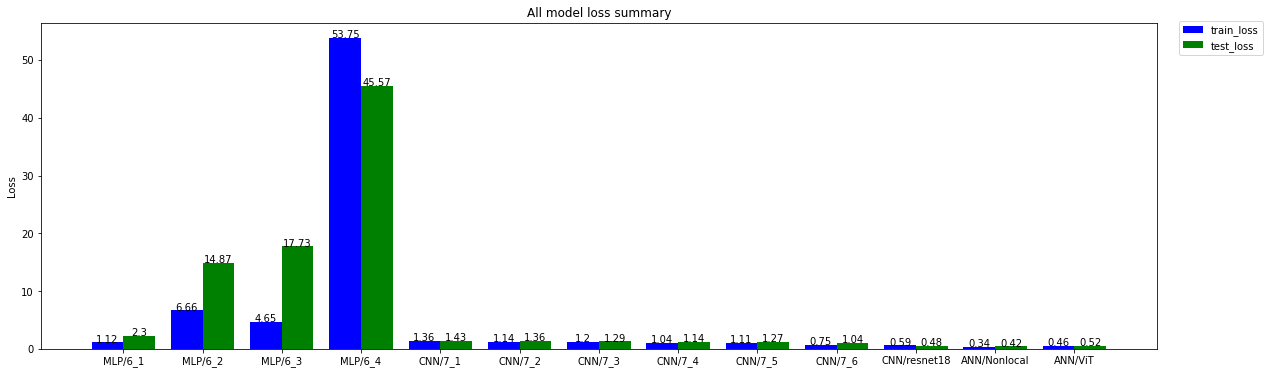

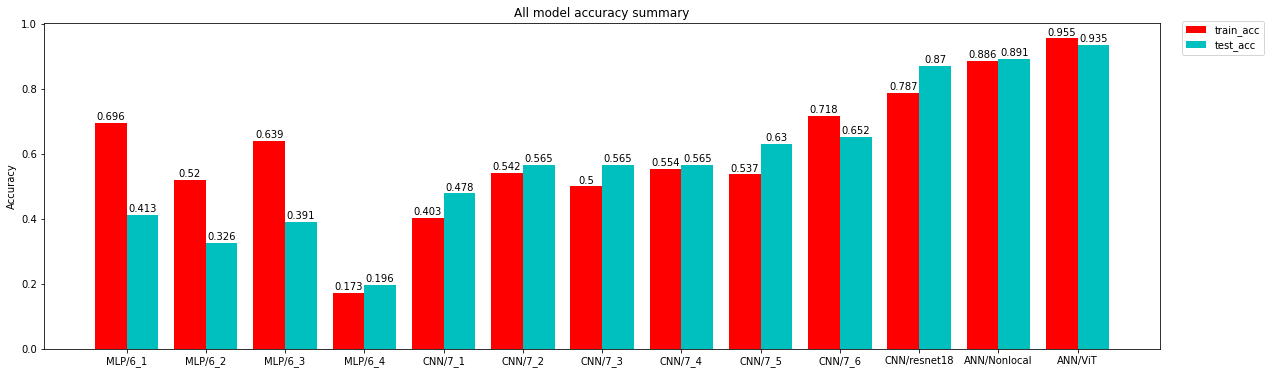

In [126]:
model_type = 'All'
bar_data_All = dict()

for model_name, value in model_dict.items():
    if 'nonlocal' in model_name:
        model_name = 'ANN/Nonlocal'
    history = value['history']
    index_highest_accuracy_test = np.argmax(history[:, -1], axis=-1)
    train_loss, test_loss, train_accuracy, test_accuracy = history[index_highest_accuracy_test, :]
    bar_data_All[model_name] = (train_loss, test_loss, train_accuracy, test_accuracy)

bar_plot(bar_data_All, model_type, offset=0.05, figsize=(20, 6))

In [127]:
_ = gc.collect()

Based on Shanghai Garbage Classification System, we propose our solution to help citizens to obtain the accurate trash type based on the images so that the difficulty of protecting environment is lower. We Fetch the images of garbage by designing our **scrawler** and modify their labels like Recyclable - Glasses to adapt our multi-class garbage classification model. And some data pre-preprocessing technologies, such as **Kmeans**, **Geometric Smote**, etc., are used in our research. Based on the optimal model among **MLP, CNN, and ANN**, users can get quick and accurate judgments on the waste types, improving the garbage classification quality. **ANN** got a best accuracy of **0.935** on the test set. Also, a simple **front-end layer** is included in our solution that allows users to interact easily.
  
We must acknowledge certain limitations of the present study that can pose implications for future research. Future efforts can be devoted to the further application on large scale garbage classification and performance improvement.
  
The following conclusions was made based on the findings of the study:

1. As can be seen from the figures, CNN and ANN models owns better performance on test datasets, which means that the improvement introduced in these models actually enhance their performances.

2. For MLP model:
    * `MLP/6_1` is the most basic model - multi-layer MLP with an accuracy of **0.413** on test dataset.
    * Although the introduction of **weight initialization** and **weight decay** deteriorate the performance, they may have the potential to slightly solve the overfitting problem.
        * Generation gap:
            * `MLP/6_1: 0.283`
            * `MLP/6_2: 0.194`
            * `MLP/6_3: 0.248`
        * Also, as for their influence on the inhibition of the weight and the symmetry of the structure, we also made a certain analysis by drawing the distribution of the weights.
    * Finally, we try to use **genetic algorithm** to update weight instead of gradient descend method.
        * To simply our research, we only train the model on a mini batch.
        * As can be seen in the result, its performance is the poorest. But it indeeds provides an innovative idea for us to improve the model. This mechanism may be more powerful in other applications, as stated in some researches.

3. For CNN model:
    * We have trained seven different models. Compared to the basic one `CNN/7_1`, other models have certain performance improvements. The **resnet18** model using **transfer learning** achieved the highest accuracy of **0.87** on the test dataset.
    * We extend the model in both width and depth directions:
        * **Width**: 
            * **Inception**(`CNN/7_2`): The information of different scales of the image is extracted through the multiple convolution kernel structures of Inception, and finally fused to obtain a better representation of the image.
            * **Bottleneck**(`CNN/7_3`): Since Inception uses multiple convolution kernels on one layer, there is no doubt that the parameters will be more than the basic model. Adding Bottleneck's 1x1 convolution kernel can alleviate this probelm. (This trick is also considered in many other structures to reduce the computation)
        * **Depth**:
            * **ResNet**(`CNN/7_4`): ResNet includes a residual branch and a short-cut branch, which is one more short-cut branch than the traditional convolutional structure, used to transmit low-level information so that the network can be trained deeply. Due to the shortcut layer, the weight update is performed in an additive manner, which alleviates problems such as gradient disappearance.
            * **SeNet**(`CNN/7_5`): Actually, this structure does not belong to the content of extending the model in the depth direction, but we combine it with ResNet and it is better to be explained in this section. SeNet improves the accuracy by modeling the correlation between feature channels and strengthening important features.
        * As can be seen from the results, except for the introduction of Bottleneck, the introduction of each trick can improve the performance on test dataset. (And introduction of Bottleneck helps us to reduce the memory usage)
    * After we **incoporate these four tricks** into one model `CNN/7_6`, the high accuracy on the training set indicates that the model can better learn the features of the images. Also the performance on the test set also has a certain improvement. It is believed that with reasonable stacking and structural mixing, this model can perform better.
    * Since exploring effective stacking or hybrid approaches requires a lot of effort, we chose **ResNet18** to simplify our research.
        * To obtain better performance, **transfer learning** is used in this model. Transfer learning focuses on storing solved models of existing problems and leveraging them on other different but related problems.
        * Model `CNN/resnet18` gets an accuracy of 0.87 on the test dataset, which is twice that of the most basic MLP model. It is proved to be a effective model in our research.

4. For ANN model:
  * We add a non-local block for image **self-attention** in the resnet-18, result demonstrate that the performance will be further improved to **0.891** after the attention block is plugged in.
  * Besides, we also use the state-of-the-art **visual-transformer** which does not use traditional CNN architecture and only used stacked self attention block. This method outperforms all other method in terms of the accuracy on the test set by achieving an accuracy of **0.935** on the test set.

5. Some vialization technologies are used in our final solution.
    * We use **t-SNE** to map the features to 2-dimension data, which suggests that it is hard to effectively classify the images into clusters.
    * We use bokeh package to create an **interative plot** to give a better analysis of our data. The results can be reached through [garbage_classification_plot_interactive](https://hewenbin-bobo.github.io/garbage_classification_plot_interactive.html).
    * For further application in real life, we also use gradio package to create our **simple app** deployed on Hugging Face, which provides the function of online prediction. The app can be reached through [CS5242-Project-Garbage-Classification-Shanghai (Gradio)](https://huggingface.co/spaces/wenbin1996/CS5242-Project-Garbage-Classification-Shanghai).